## Import Libraries

In [1]:
from fastai.vision import *
from fastai import *
from fastai.data_block import *

from pathlib import Path

from unet import dice_loss, dice_score, predict, plot_predictions, eval_preds

### Normalize Raw Images

Normalize the raw MRI scans and zero out the background (any pixels with negative value gets zero value). If you don't zero the background, the model will have difficulty predicting the brain mask. Note that this step needs to be done just once for the training, validation, and test raw images.

In [2]:
import sys
sys.path.extend(['../'])
from Vent_Seg_Preprocessing.helper import normalize, extract_brain
import numpy as np

In [3]:
train_raw_images_path = Path("/data/public/Segmentation_Dataset/CT_Dataset/train/raw_images")
validation_raw_images_path = Path("/data/public/Segmentation_Dataset/CT_Dataset/validation/raw_images")
test1_raw_images_path = Path("/data/public/Segmentation_Dataset/CT_Dataset/test1/raw_images")
test2_raw_images_path = Path("/data/public/Segmentation_Dataset/CT_Dataset/test2/raw_images")

In [4]:
# for fp in list(train_raw_images_path.iterdir()):
#     name = str(fp).split("/")[-1]
#     f = np.load(fp)
#     normalized_f = normalize(f)
#     normalized_f[normalized_f < 0] = 0
#     np.save("/data/public/Segmentation_Dataset/CT_Dataset/train/normalized_raw_images/{name}".format(name=name), normalized_f)
    

In [5]:
# for fp in list(validation_raw_images_path.iterdir()):
#     name = str(fp).split("/")[-1]
#     f = np.load(fp)
#     normalized_f = normalize(f)
#     normalized_f[normalized_f < 0] = 0
#     np.save("/data/public/Segmentation_Dataset/CT_Dataset/validation/normalized_raw_images/{name}".format(name=name), normalized_f)



In [6]:
# for fp in list(test1_raw_images_path.iterdir()):
#     name = str(fp).split("/")[-1]
#     f = np.load(fp)
#     normalized_f = normalize(f)
#     normalized_f[normalized_f < 0] = 0
#     np.save("/data/public/Segmentation_Dataset/CT_Dataset/test1/normalized_raw_images/{name}".format(name=name), normalized_f)

In [7]:
# for fp in list(test2_raw_images_path.iterdir()):
#     name = str(fp).split("/")[-1]
#     f = np.load(fp)
#     normalized_f = normalize(f)
#     normalized_f[normalized_f < 0] = 0
#     np.save("/data/public/Segmentation_Dataset/CT_Dataset/test2/normalized_raw_images/{name}".format(name=name), normalized_f)

In [4]:
torch.cuda.set_device(4)
#! nvidia-smi

## Data Preparation

In [5]:
data_path = Path("/data/public/Segmentation_Dataset/CT_Dataset")
trn_img = sorted(list(Path(data_path/"train/normalized_raw_images").iterdir()))
trn_mask = sorted(list(Path(data_path/"train/brain_masks").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/normalized_raw_images").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/brain_masks").iterdir()))
test1_img = sorted(list(Path(data_path/"test1/normalized_raw_images").iterdir()))
test1_mask = sorted(list(Path(data_path/"test1/brain_masks").iterdir()))
test2_img = sorted(list(Path(data_path/"test2/normalized_raw_images").iterdir()))
test2_mask = sorted(list(Path(data_path/"test2/brain_masks").iterdir()))

In [6]:
set_of_trn_images = set([str(fp).split("/")[-1] for fp in trn_img])
set_of_trn_masks = set([str(fp).split("/")[-1] for fp in trn_mask])
set_of_valid_images = set([str(fp).split("/")[-1] for fp in valid_img])
set_of_valid_masks = set([str(fp).split("/")[-1] for fp in valid_mask])
set_of_test1_images = set([str(fp).split("/")[-1] for fp in test1_img])
set_of_test1_masks = set([str(fp).split("/")[-1] for fp in test1_mask])
set_of_test2_images = set([str(fp).split("/")[-1] for fp in test2_img])
set_of_test2_masks = set([str(fp).split("/")[-1] for fp in test2_mask])

In [7]:
print(len(set_of_trn_masks - set_of_trn_images))
print(len(set_of_trn_images- set_of_trn_masks))
print(len(set_of_valid_masks - set_of_valid_images))
print(len(set_of_valid_images- set_of_valid_masks))
print(len(set_of_test1_images- set_of_test1_masks))
print(len(set_of_test2_images- set_of_test2_masks))

0
0
0
0
0
0


In [8]:
print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")
print(f"Size of Test 1 Dataset Images: {len(test1_img)} Images")
print(f"Size of Test 1 Dataset Masks: {len(test1_mask)} Images")
print(f"Size of Test 2 Dataset Images: {len(test2_img)} Images")
print(f"Size of Test 2 Dataset Masks: {len(test2_mask)} Images")

Size of Train Dataset Images: 107 Images
Size of Validation Dataset Images: 26 Images
Size of Train Dataset Masks: 107 Images
Size of Validation Dataset Masks: 26 Images
Size of Test 1 Dataset Images: 9 Images
Size of Test 1 Dataset Masks: 9 Images
Size of Test 2 Dataset Images: 18 Images
Size of Test 2 Dataset Masks: 18 Images


In [9]:
for i in range(len(trn_img)):
    assert str(trn_img[i]).split("/")[-1] == str(trn_mask[i]).split("/")[-1]

for i in range(len(valid_img)):
    assert str(valid_img[i]).split("/")[-1] == str(valid_mask[i]).split("/")[-1]

for i in range(len(test1_img)):
    assert str(test1_img[i]).split("/")[-1] == str(test1_mask[i]).split("/")[-1]

for i in range(len(test2_img)):
    assert str(test2_img[i]).split("/")[-1] == str(test2_mask[i]).split("/")[-1]

In [13]:
class CT_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)
    
train_ds = CT_3D_Dataset(trn_img, trn_mask)
valid_ds = CT_3D_Dataset(valid_img, valid_mask)   
test1_ds = CT_3D_Dataset(test1_img, test1_mask)
test2_ds = CT_3D_Dataset(test2_img, test2_mask)

data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=3)

In [14]:
unet = VolumetricUnet(in_channel=1, out_channel=4, num_classes=1)

In [15]:
learner = Learner(data=data, model=unet)

In [16]:
learner.loss_func = dice_loss
learner.metrics = [dice_score]

In [17]:
learner.to_fp16();

In [22]:
#learner.lr_find()

In [23]:
#learner.recorder.plot()

In [24]:
#learner.fit_one_cycle(5, 3e-2)

In [25]:
#learner.save('DL_Brain_NoTL_CT_5_epochs_3e-2')

In [16]:
learner.load('DL_Brain_NoTL_CT_5_epochs_3e-2');

In [16]:
images, preds, masks = predict(learner, data)

In [27]:
IMG_NUM = 2
image = images[IMG_NUM]
pred = preds[IMG_NUM]
mask = masks[IMG_NUM]

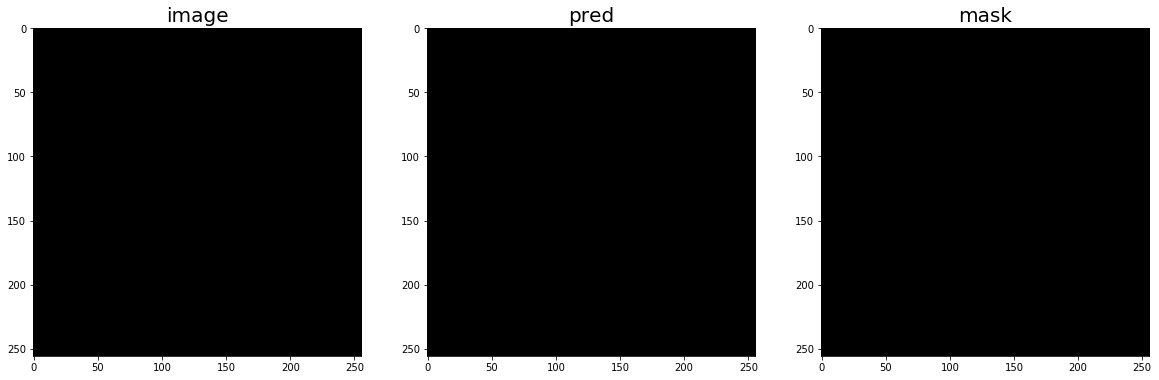

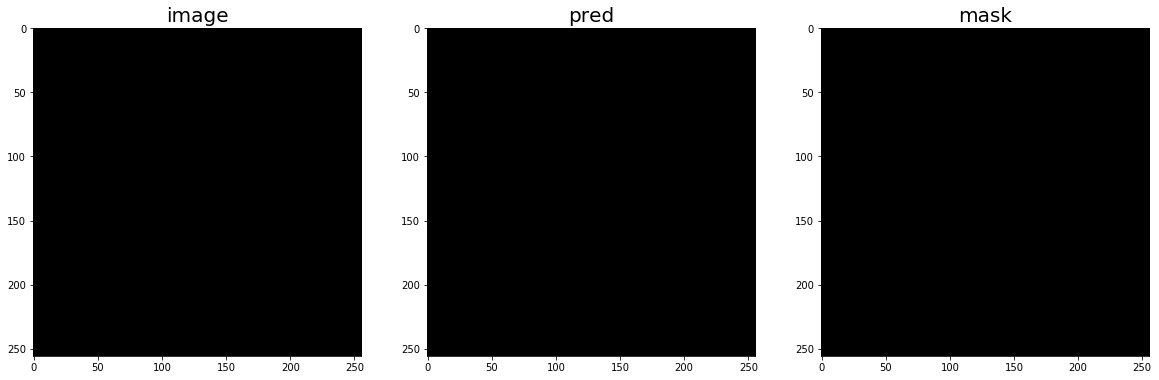

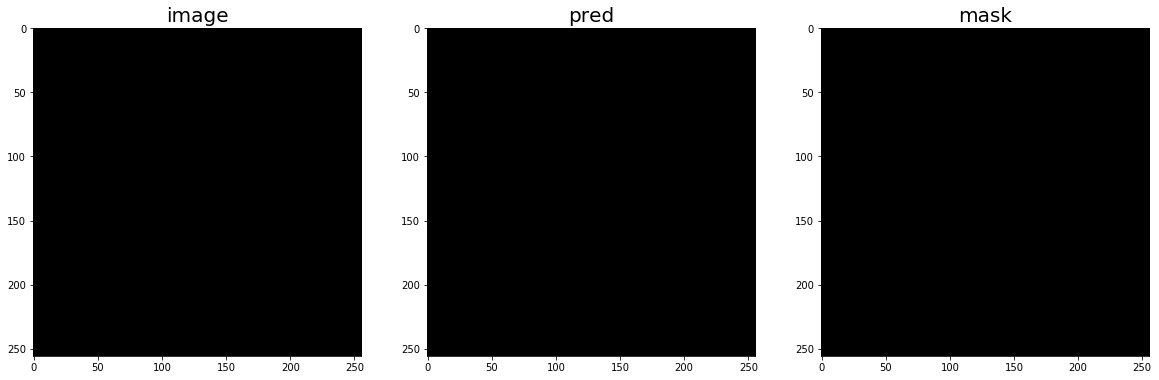

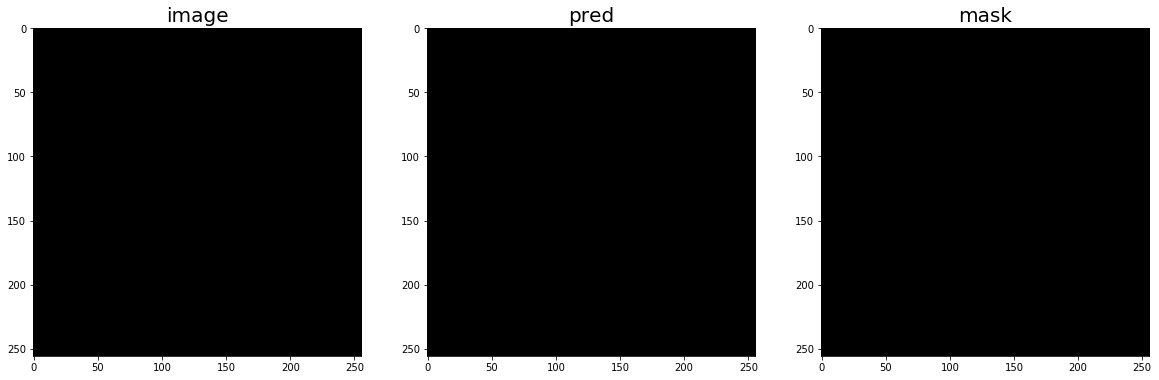

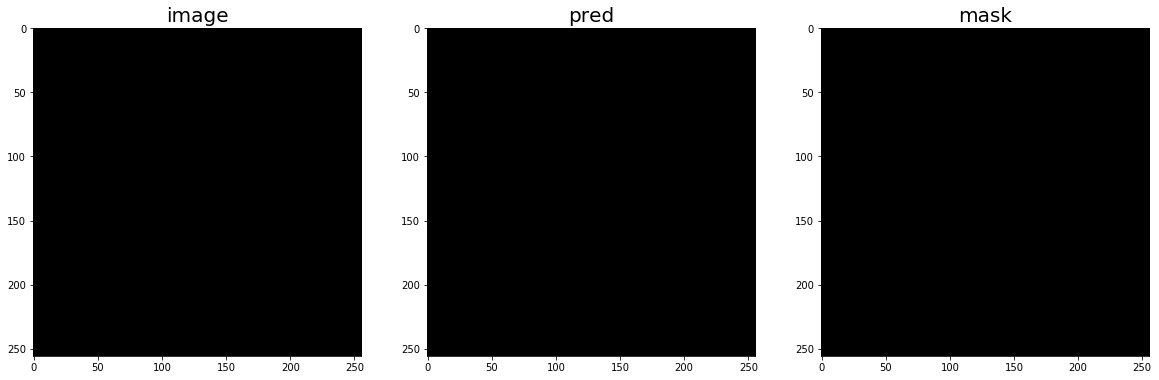

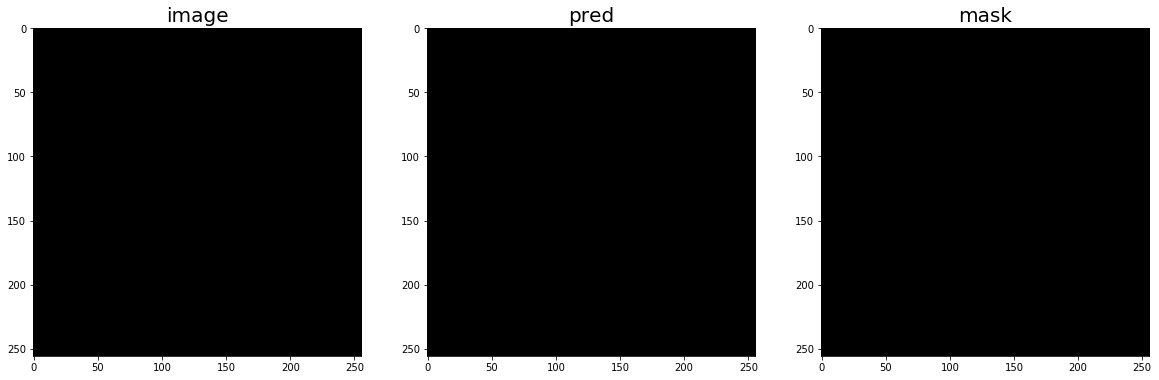

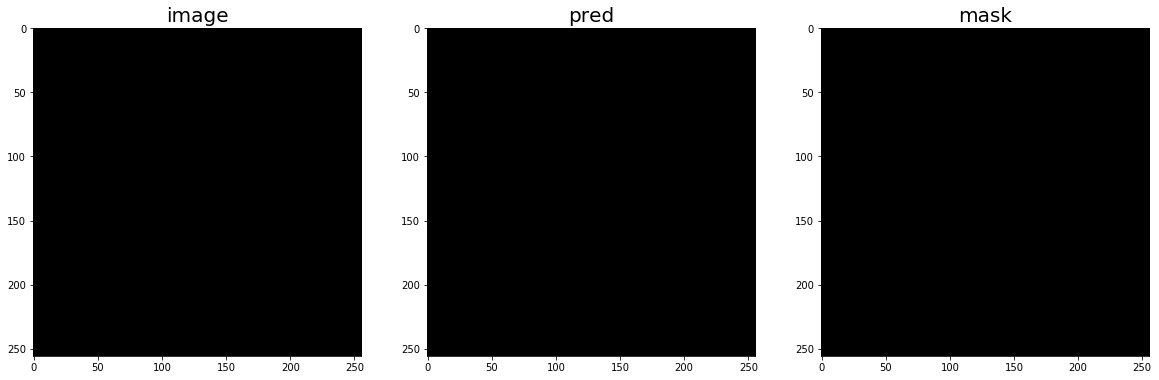

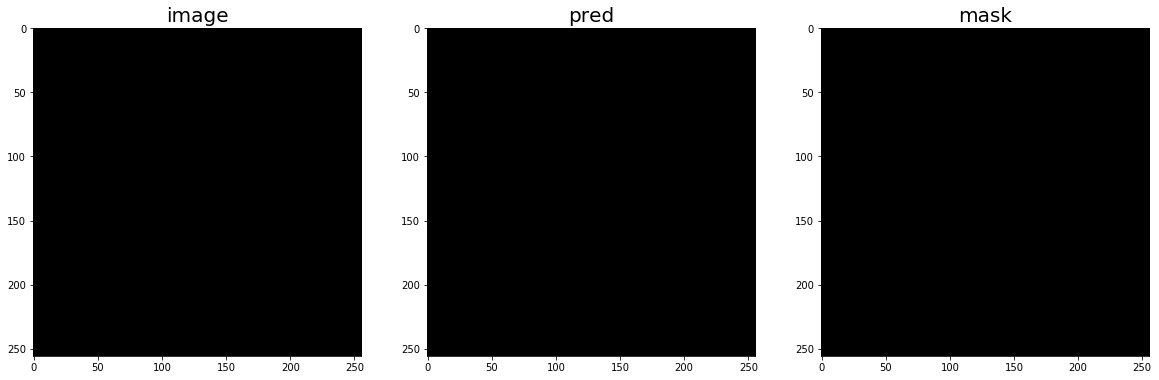

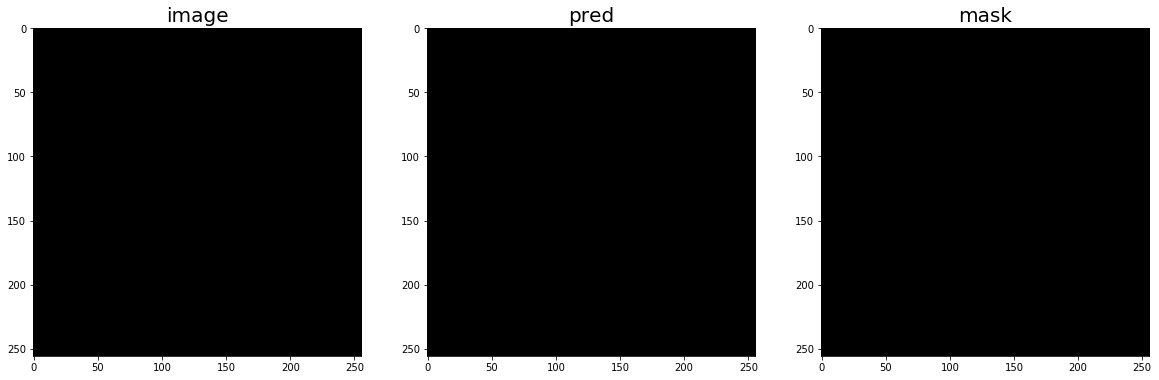

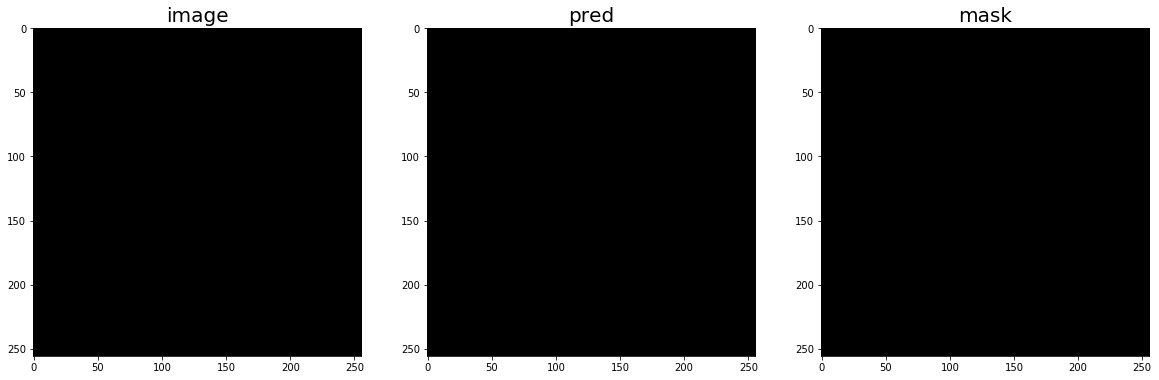

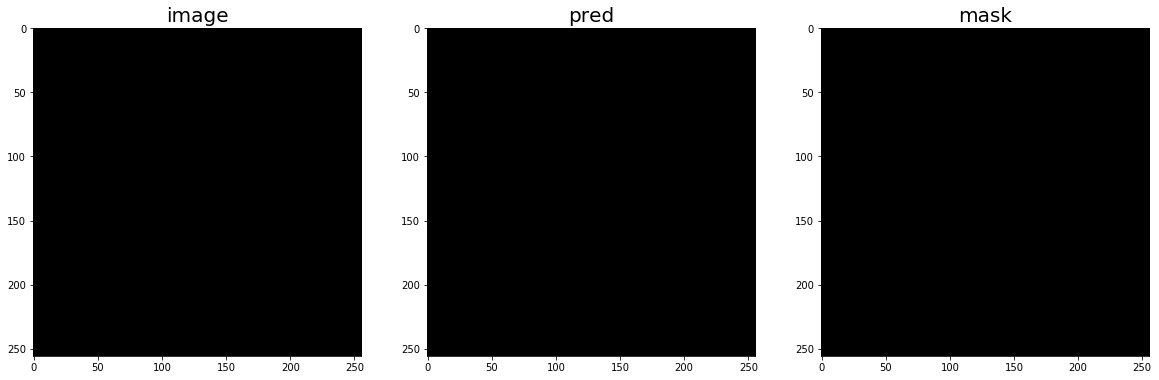

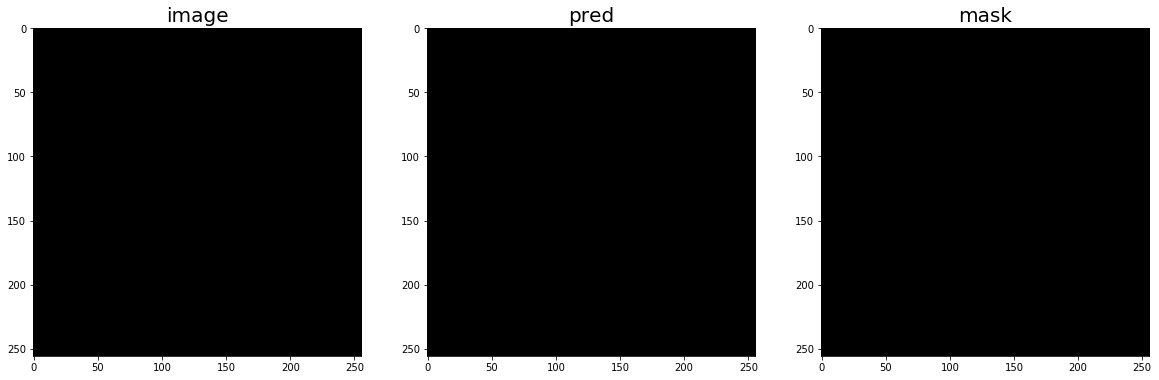

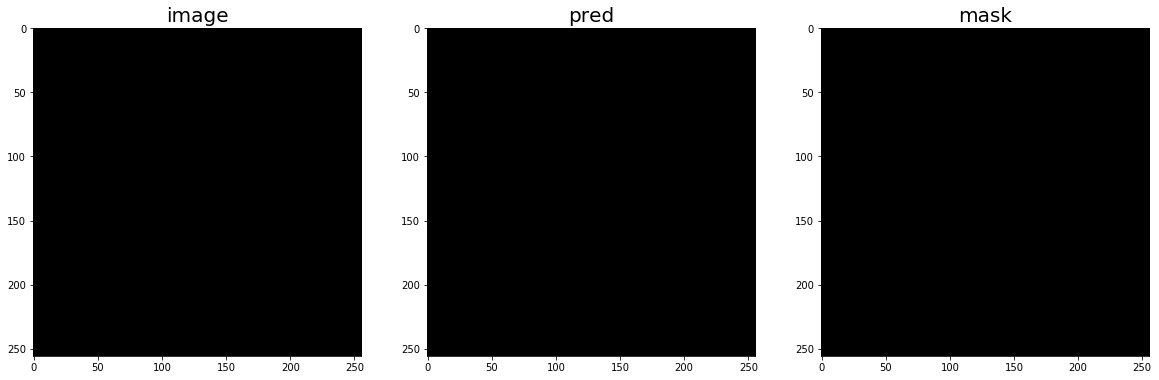

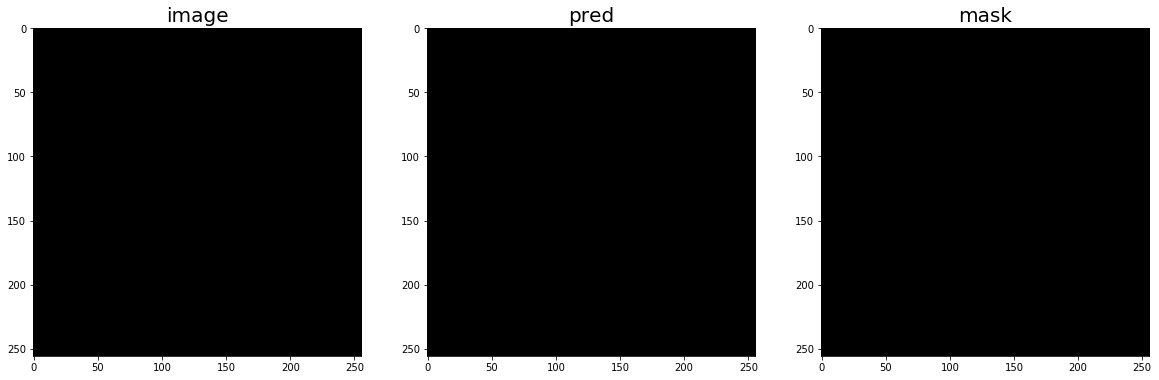

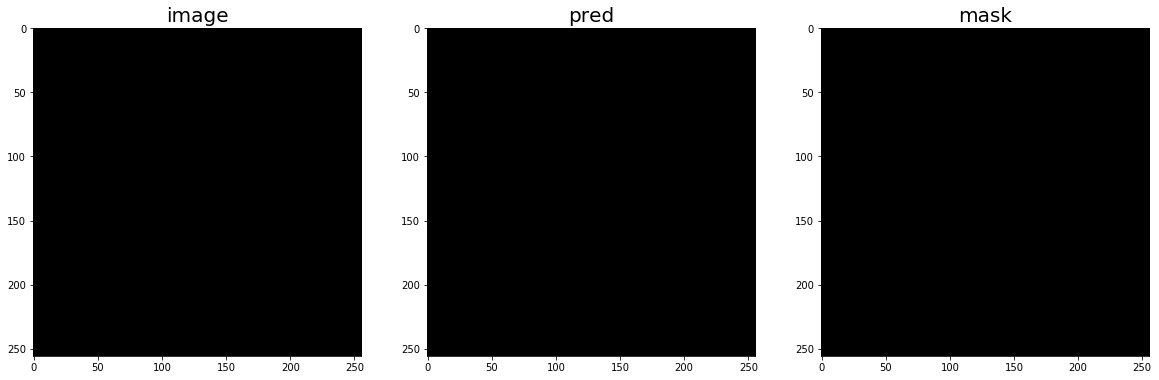

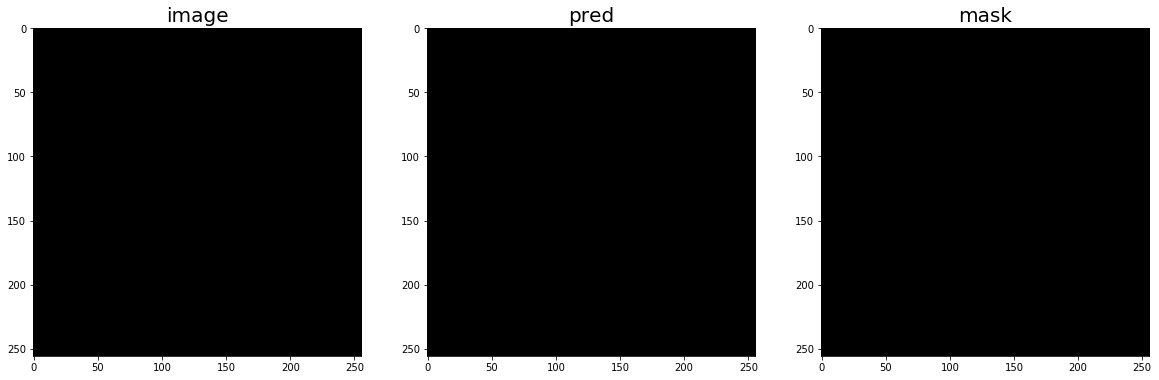

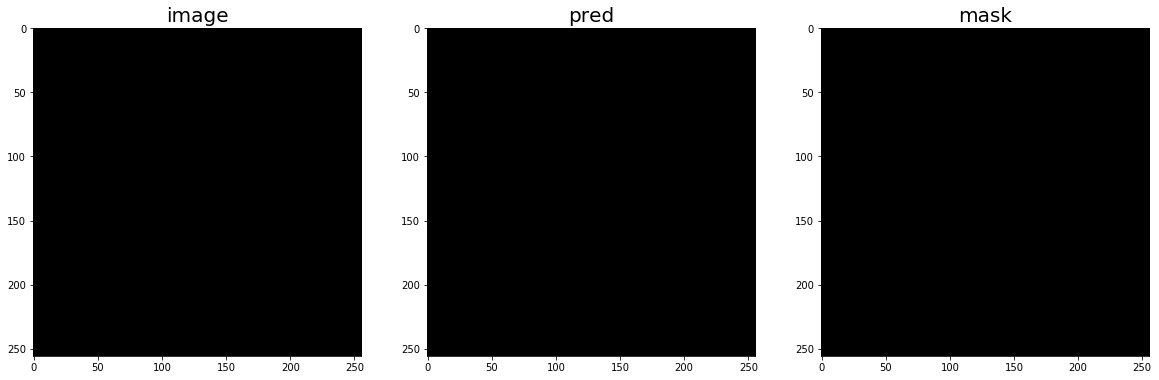

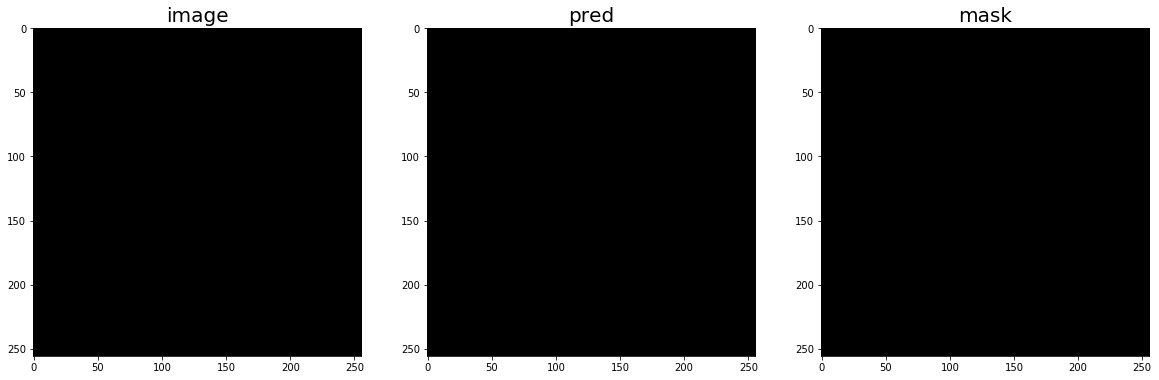

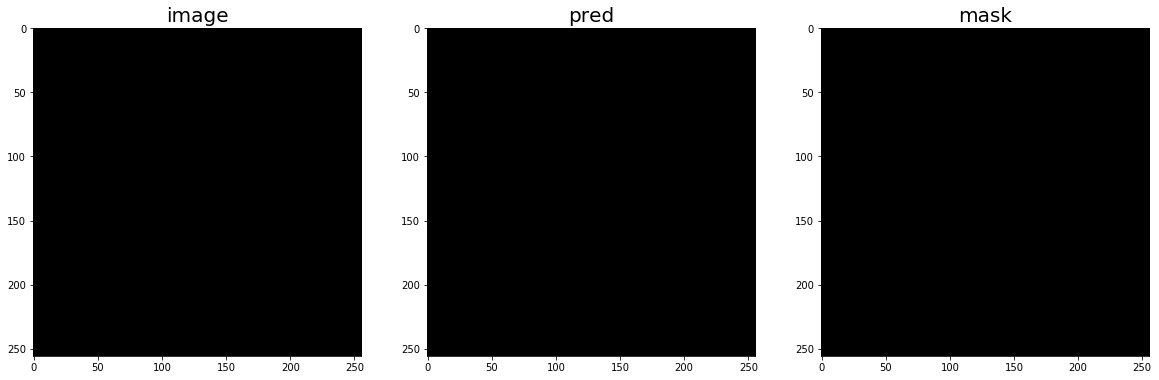

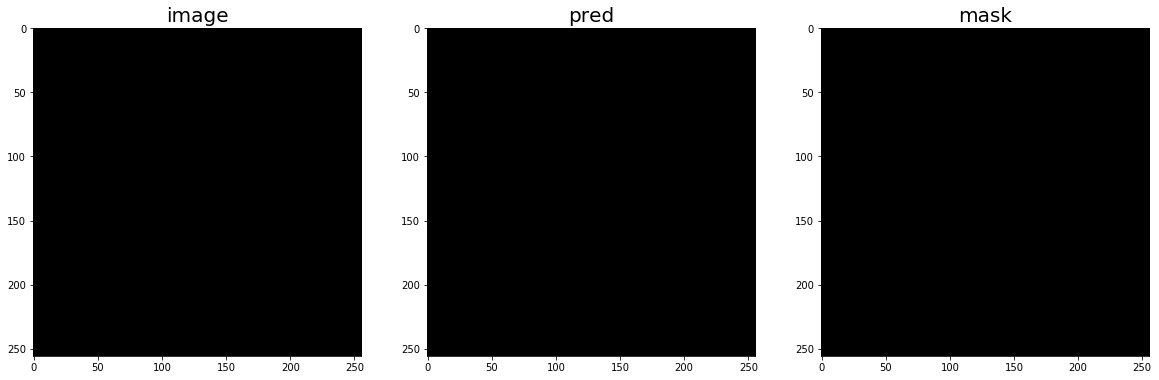

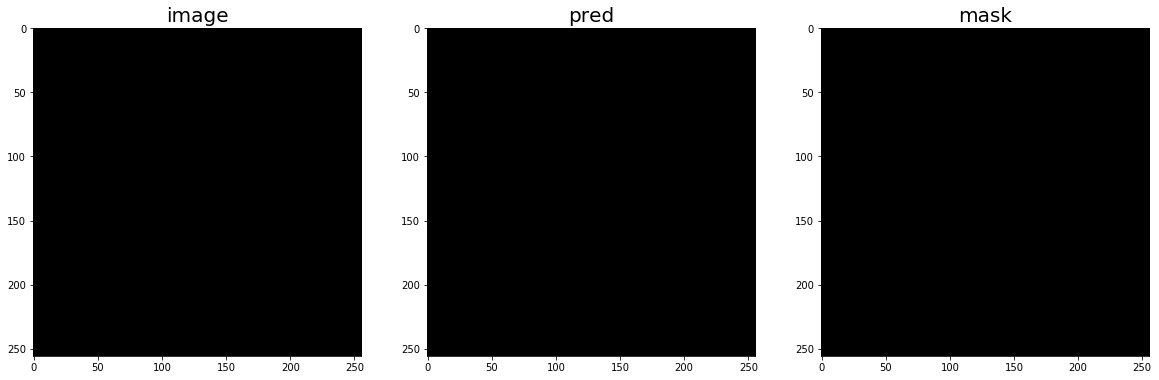

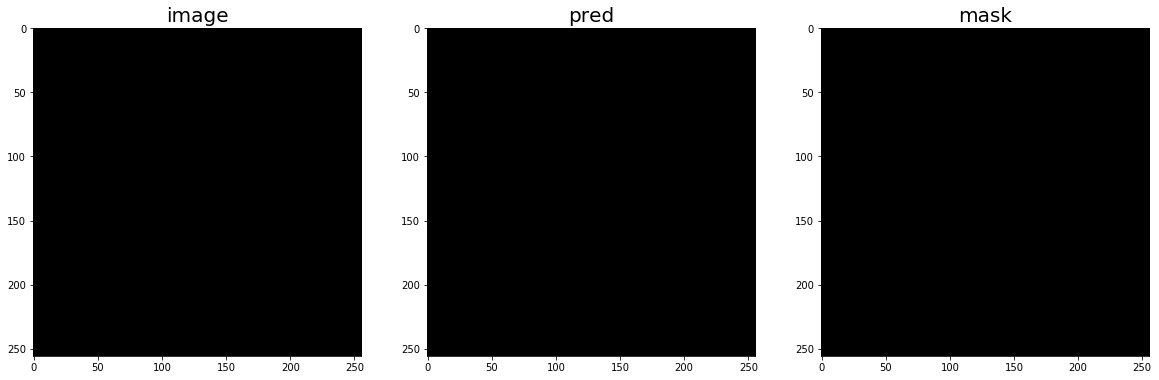

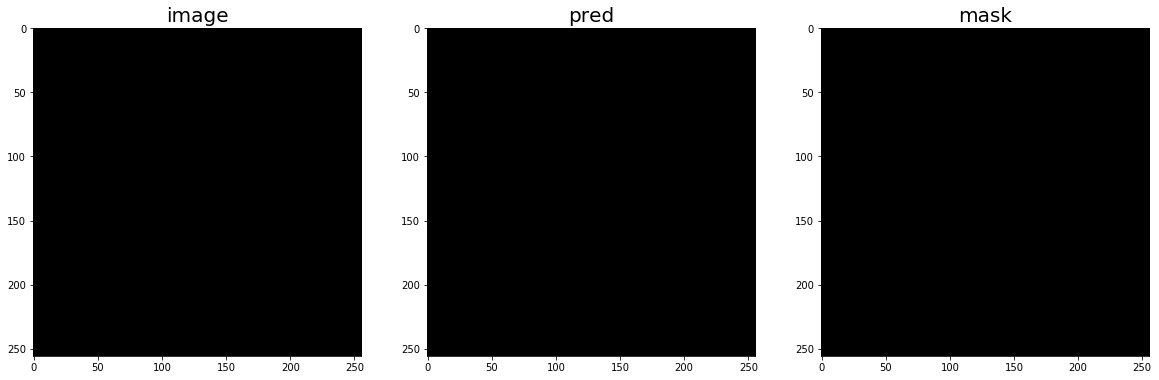

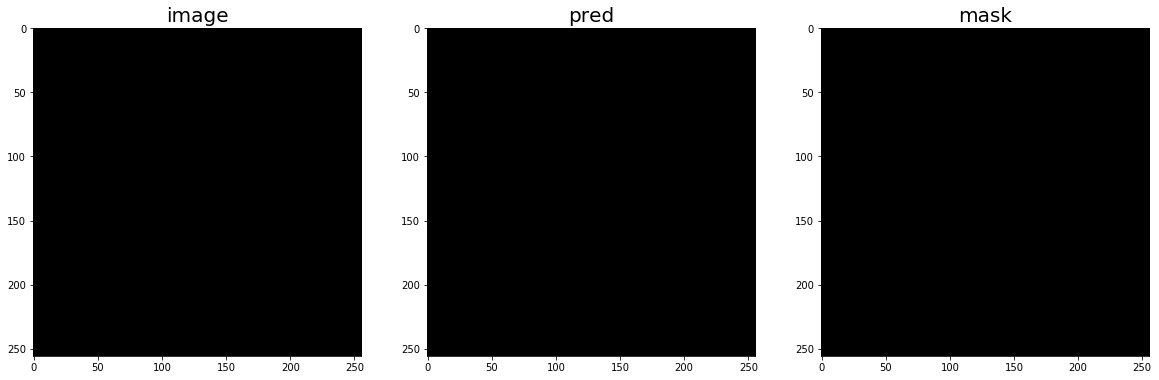

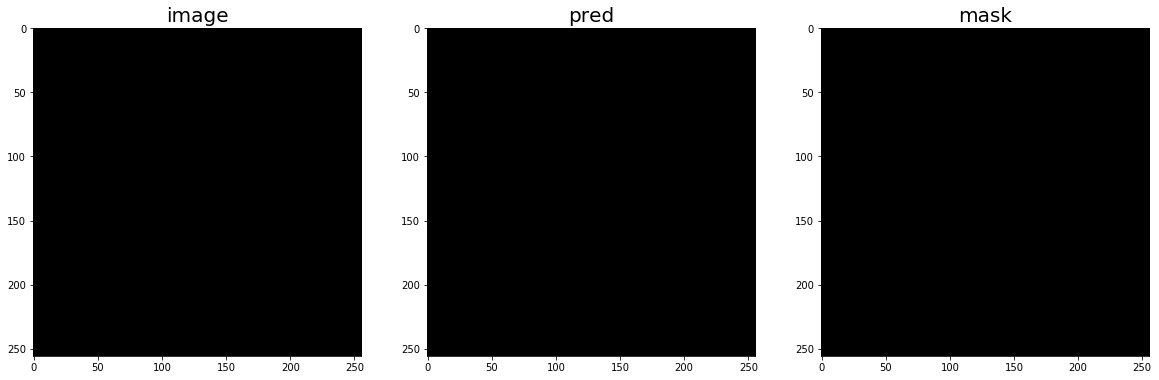

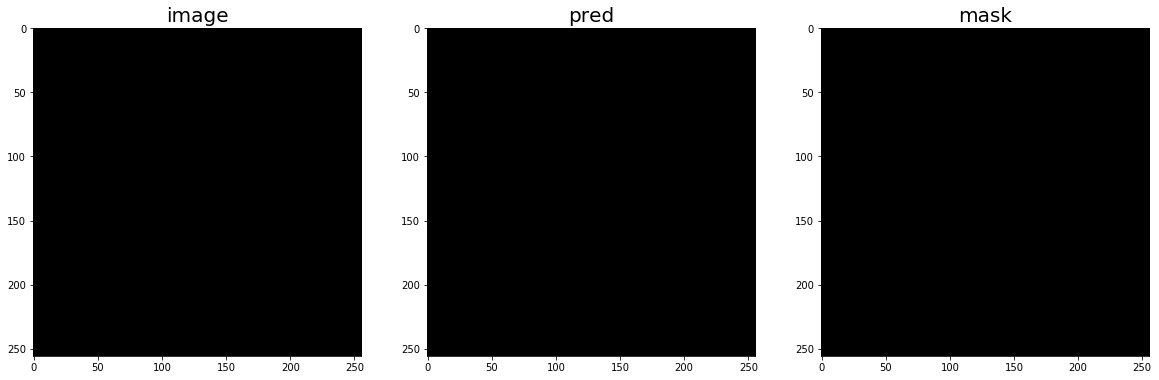

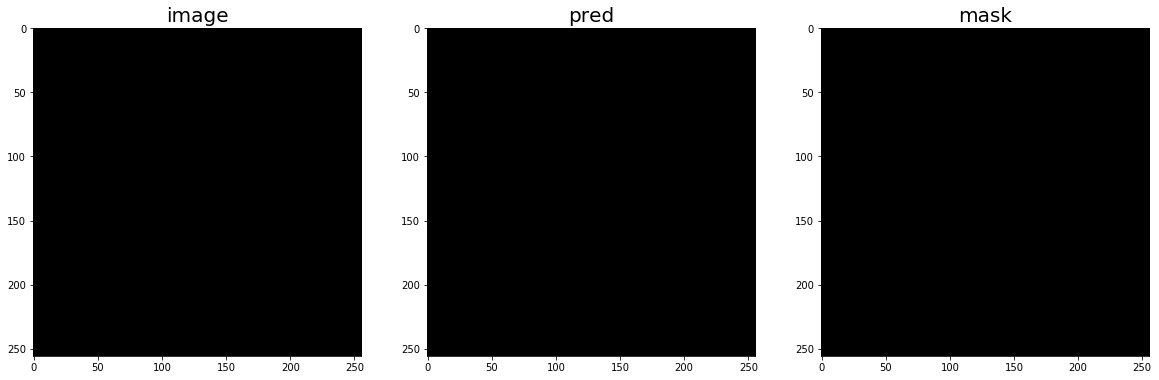

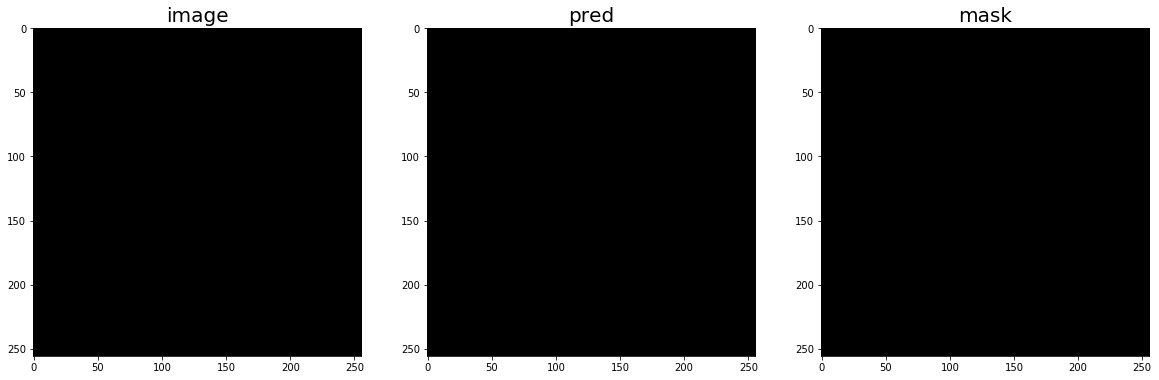

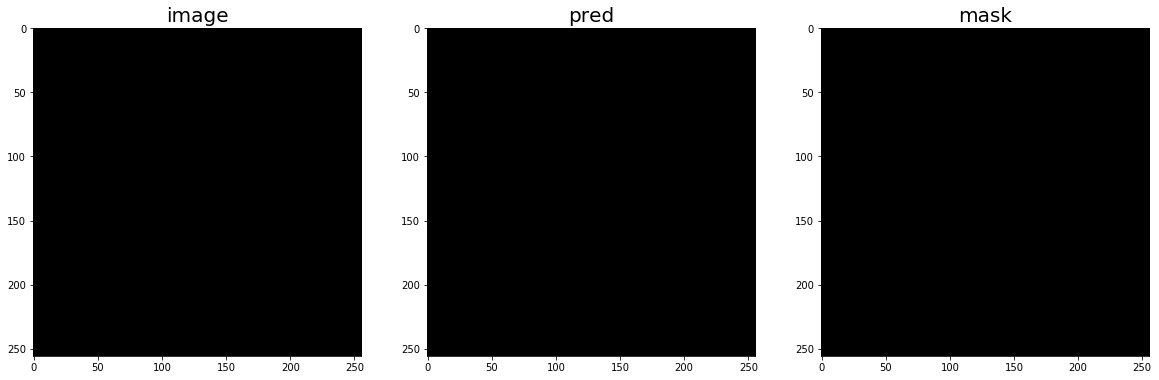

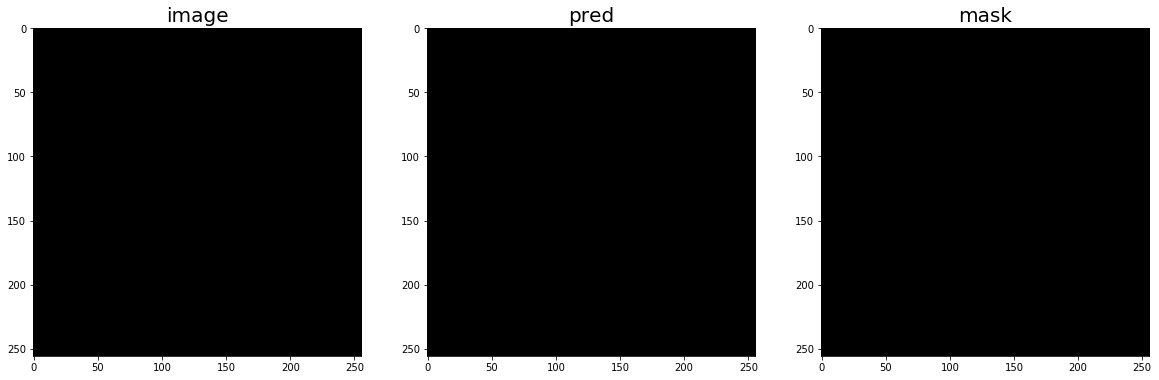

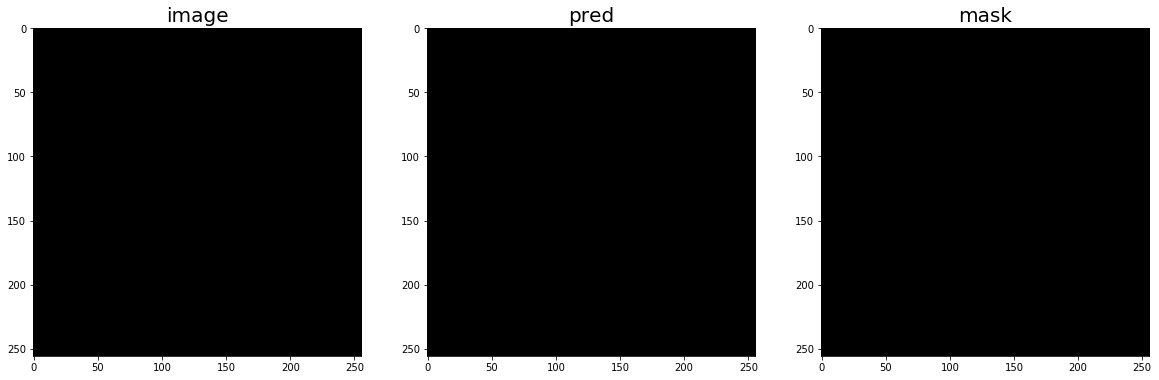

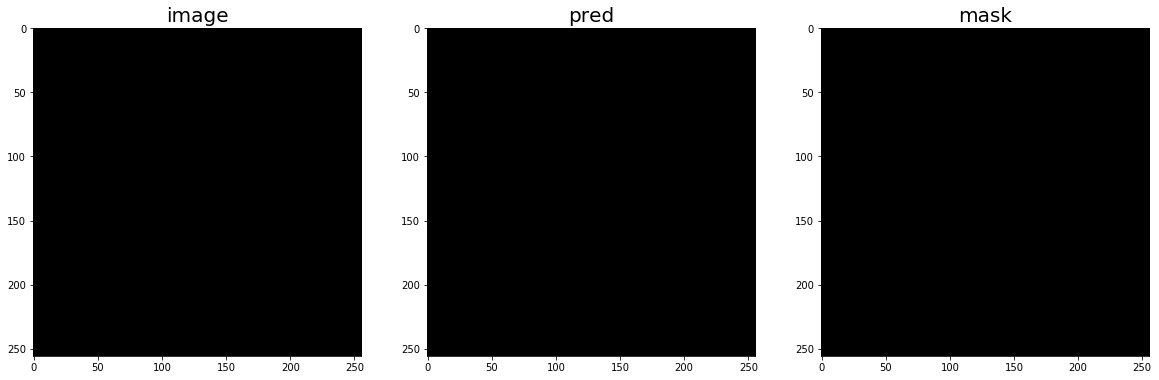

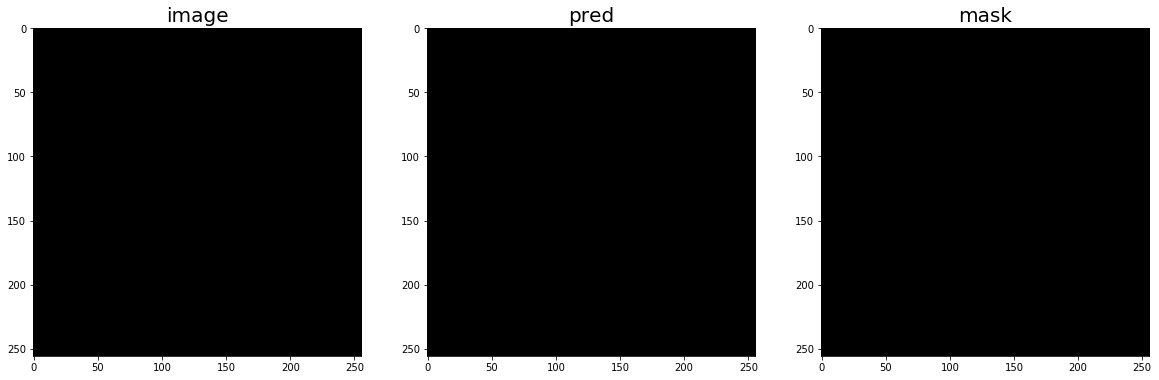

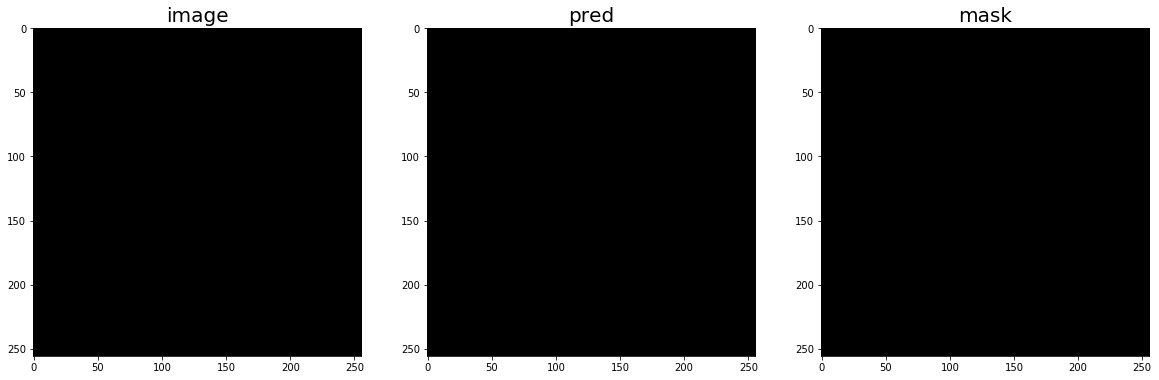

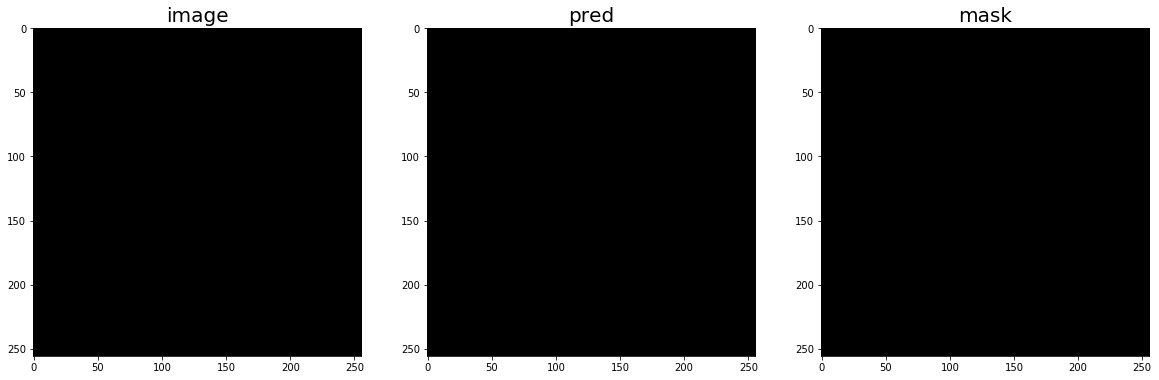

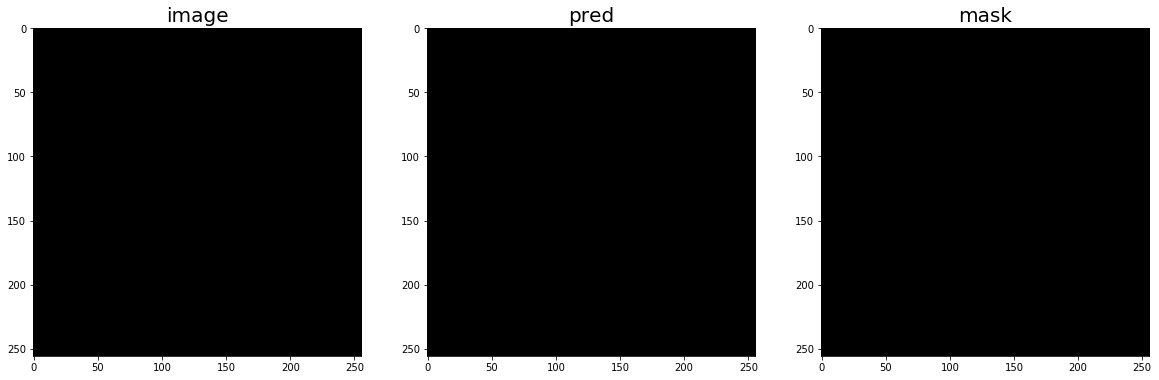

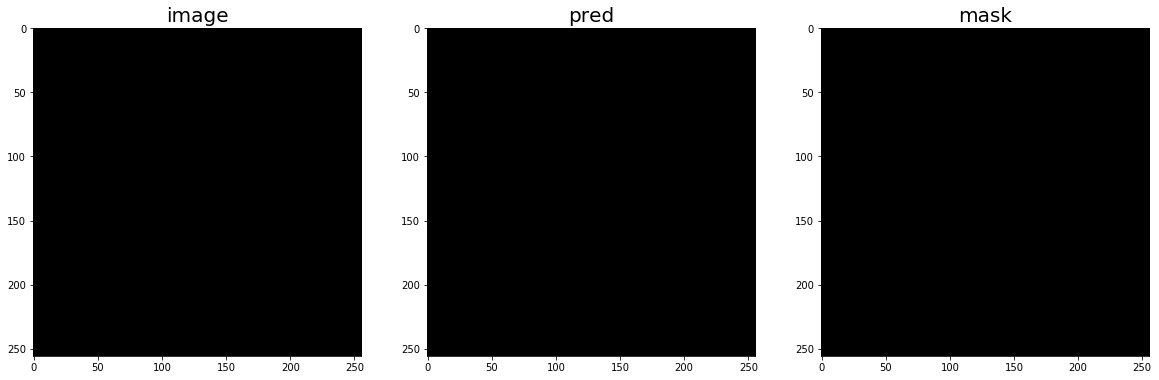

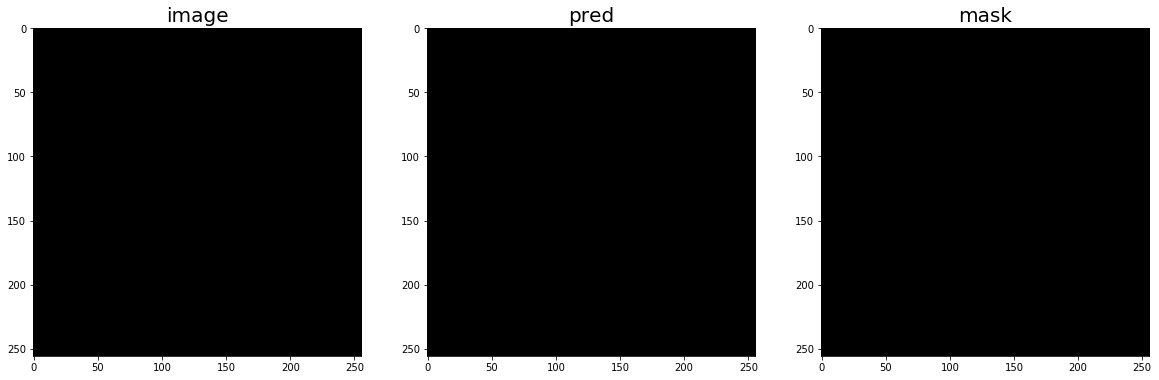

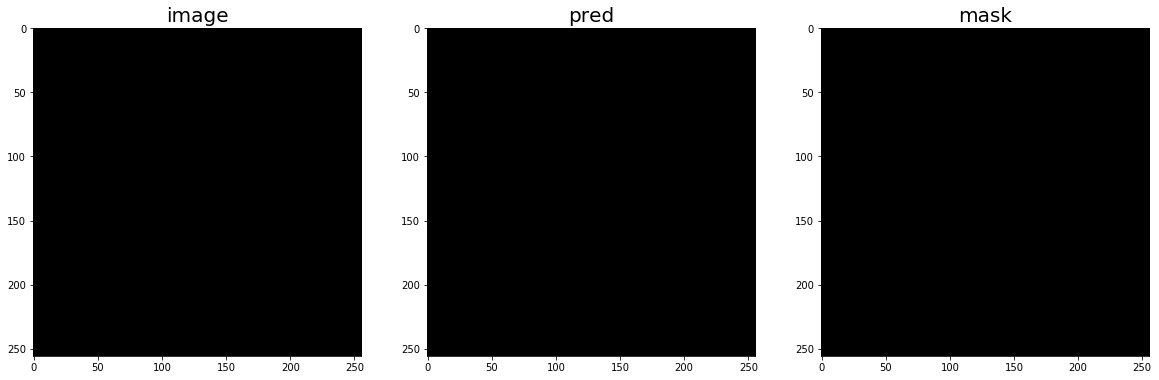

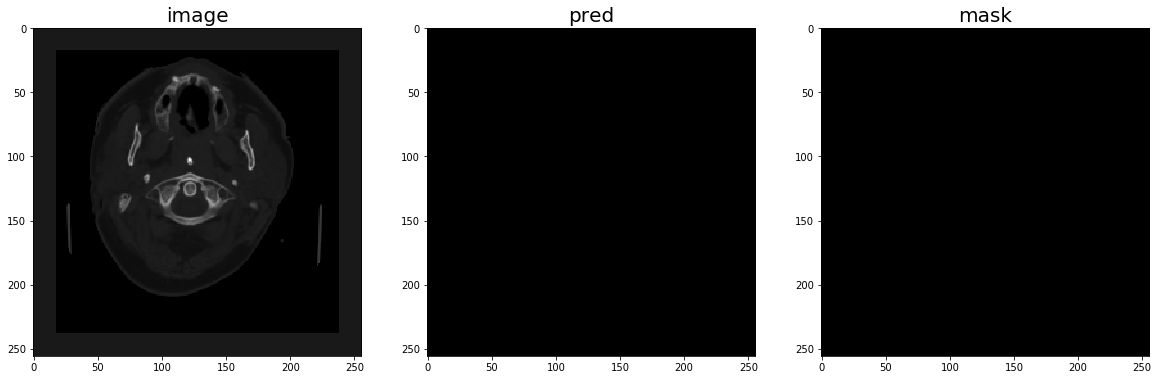

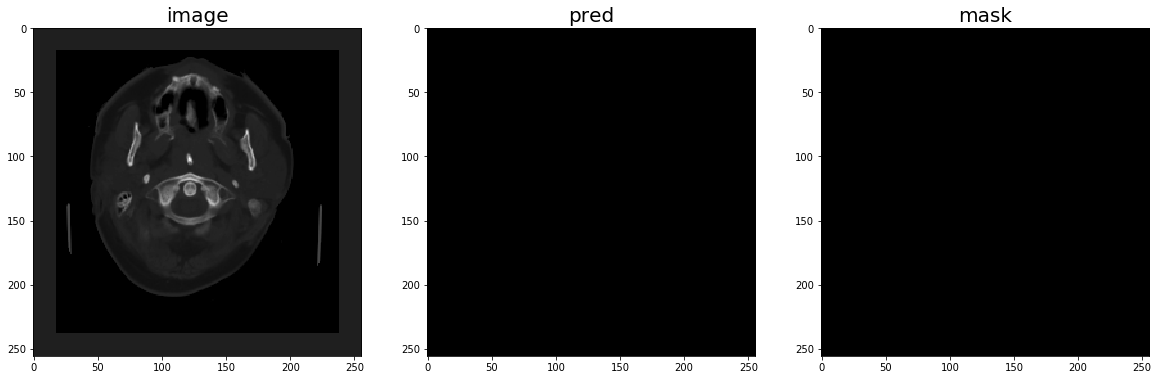

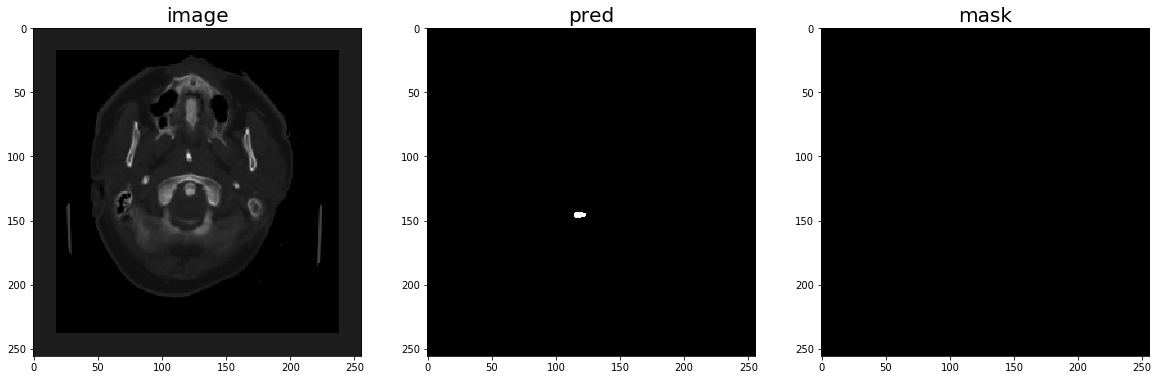

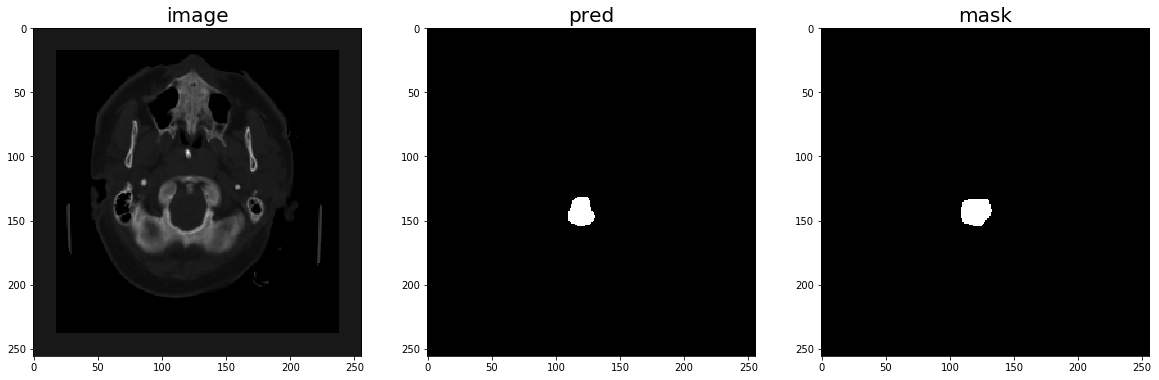

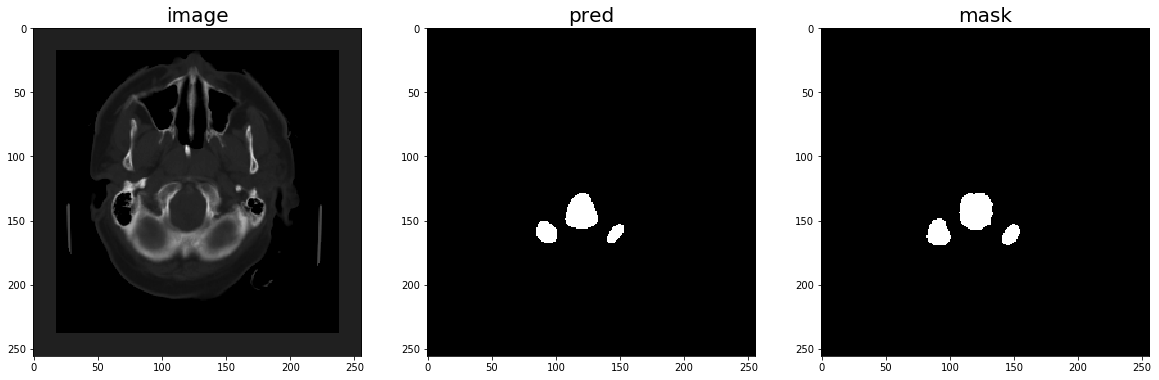

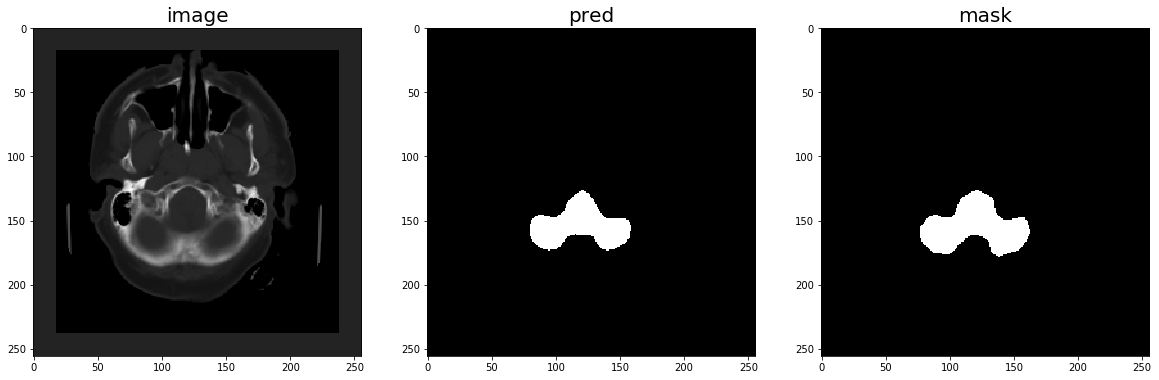

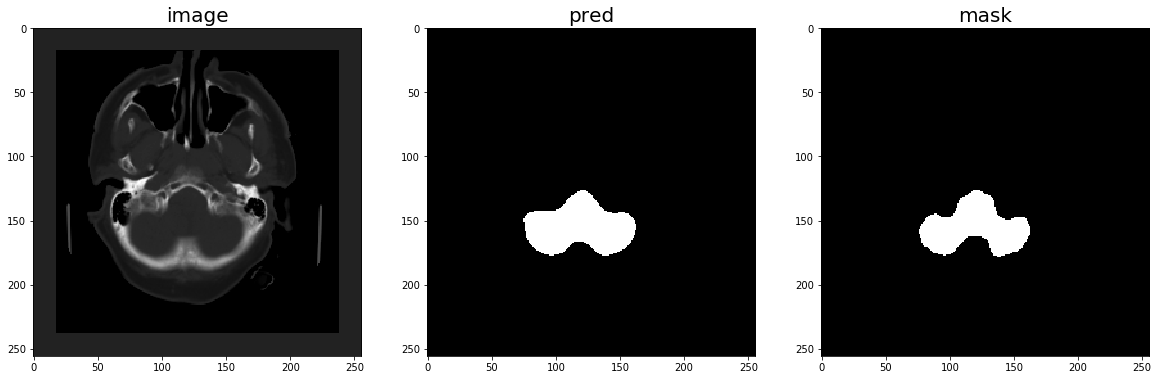

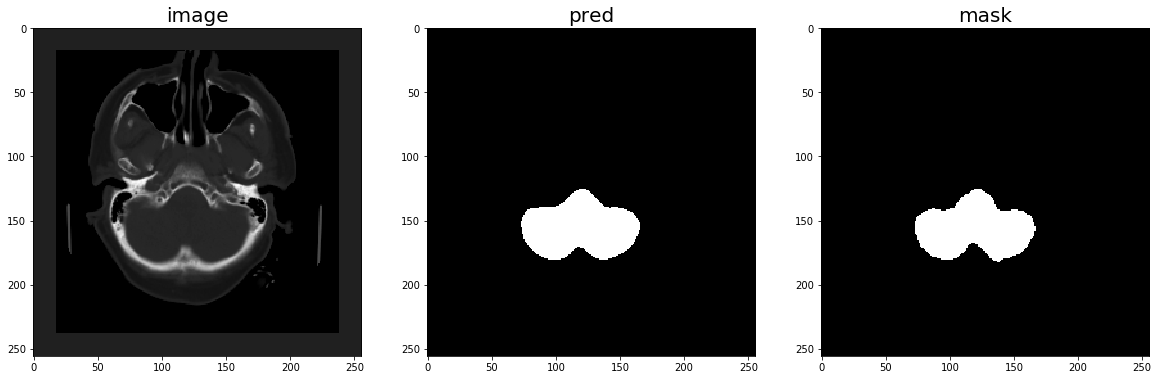

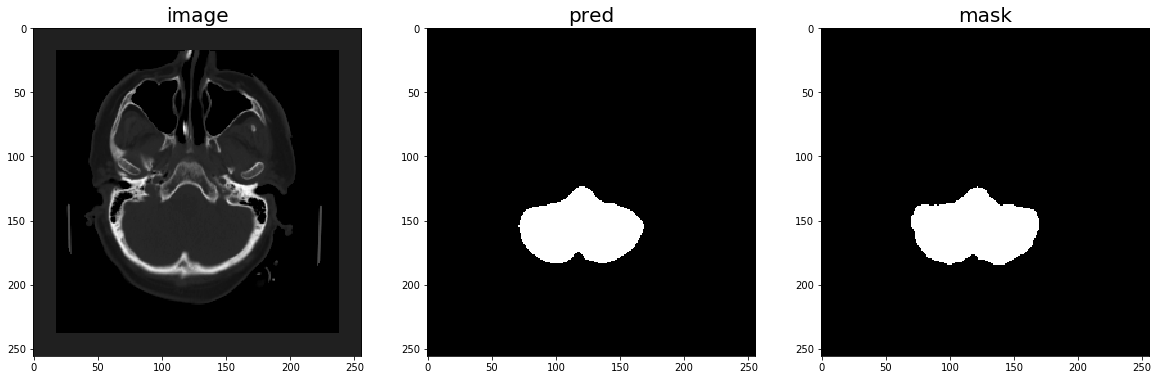

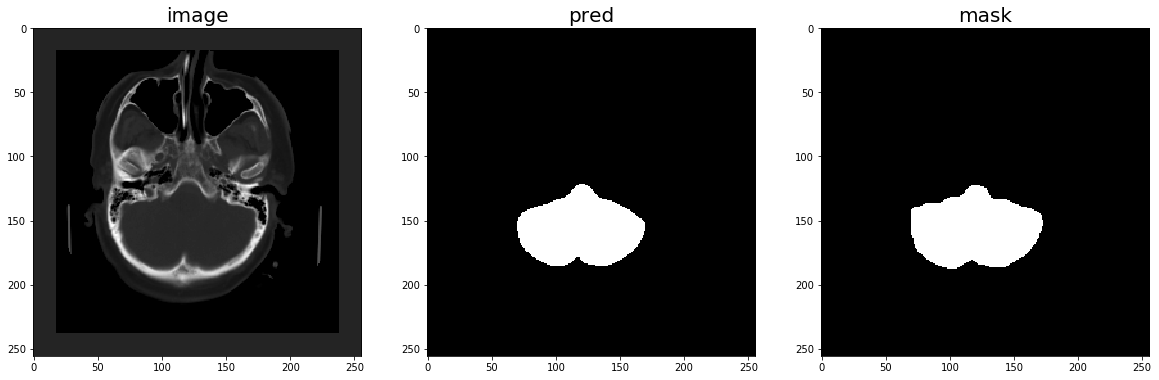

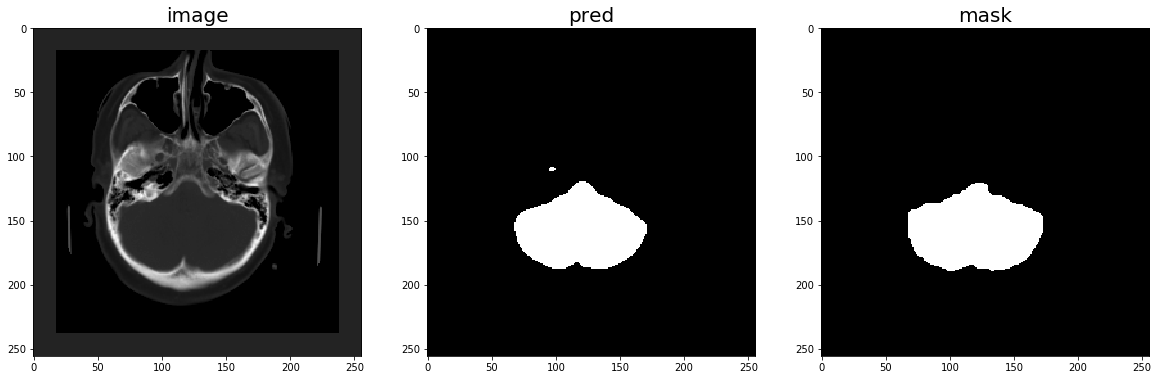

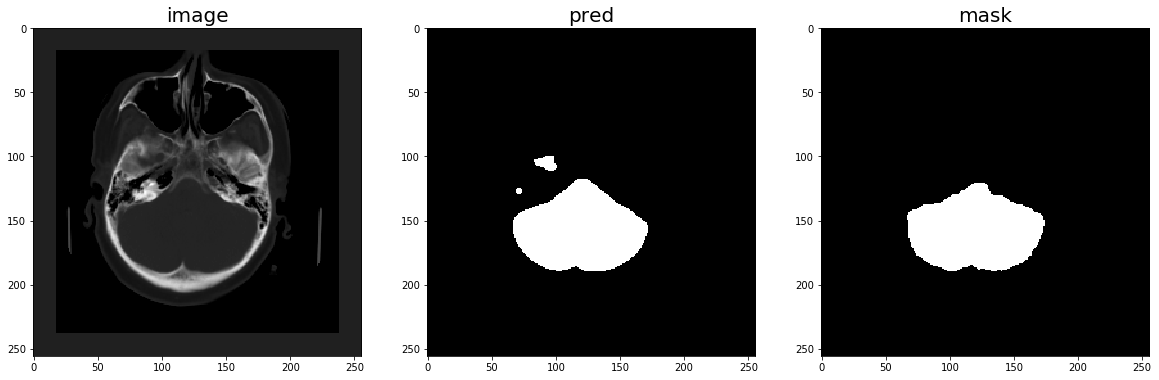

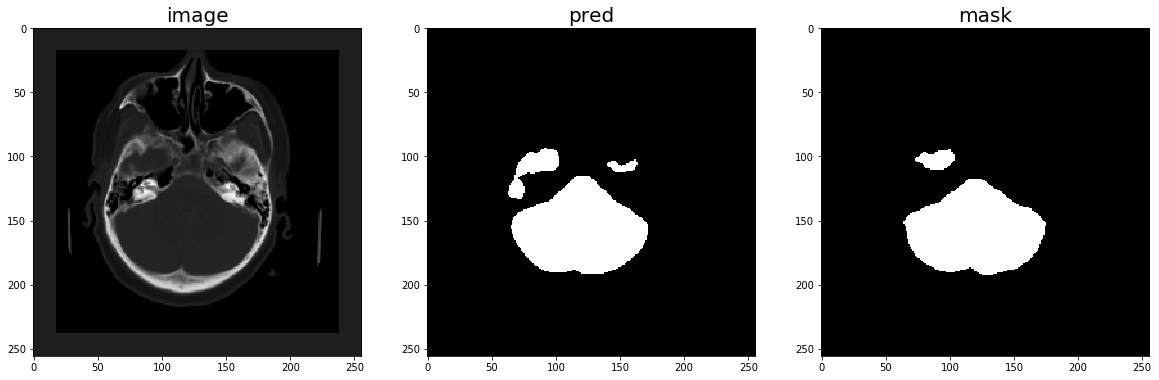

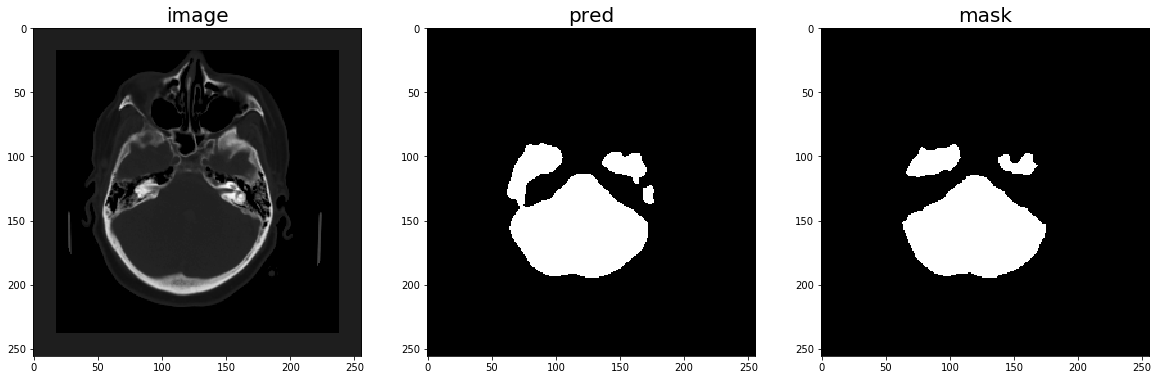

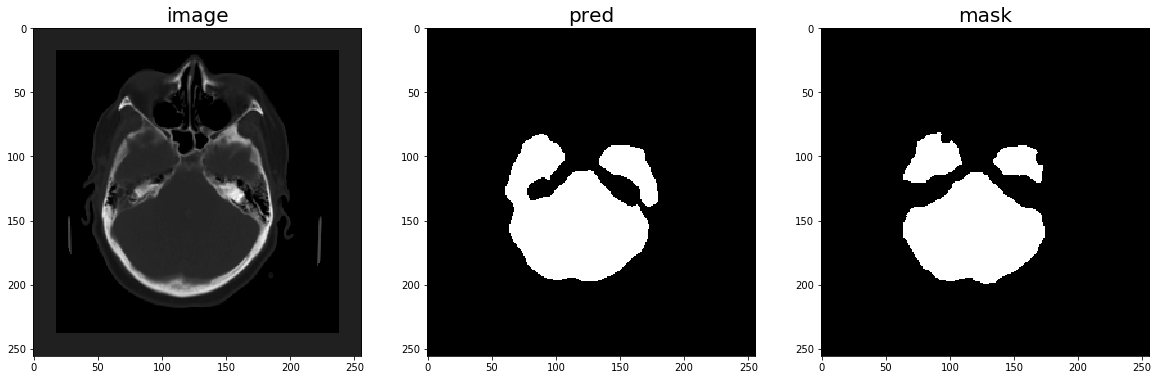

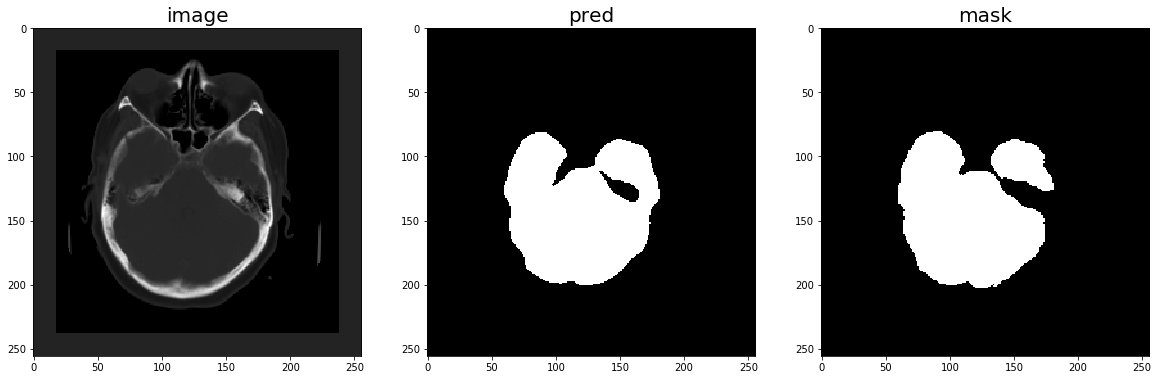

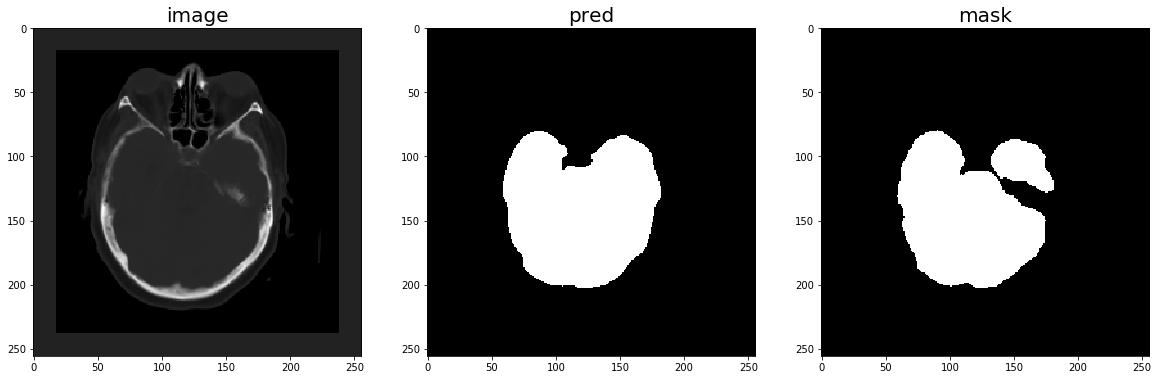

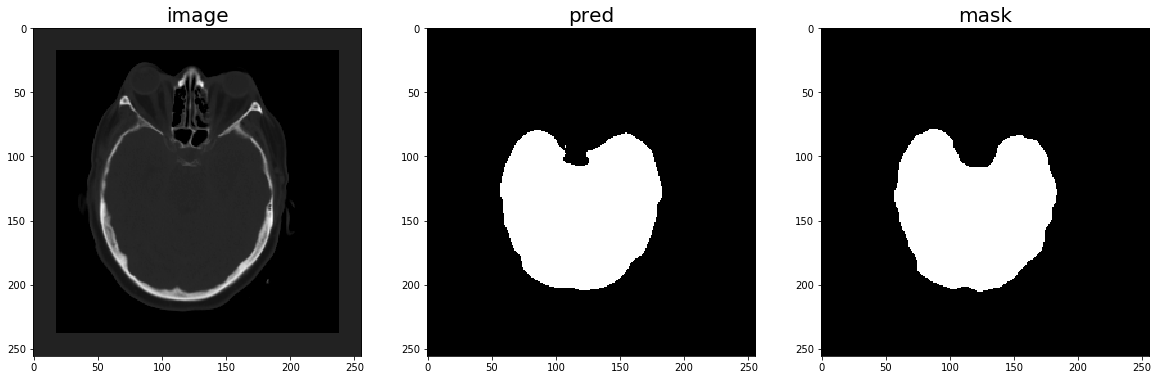

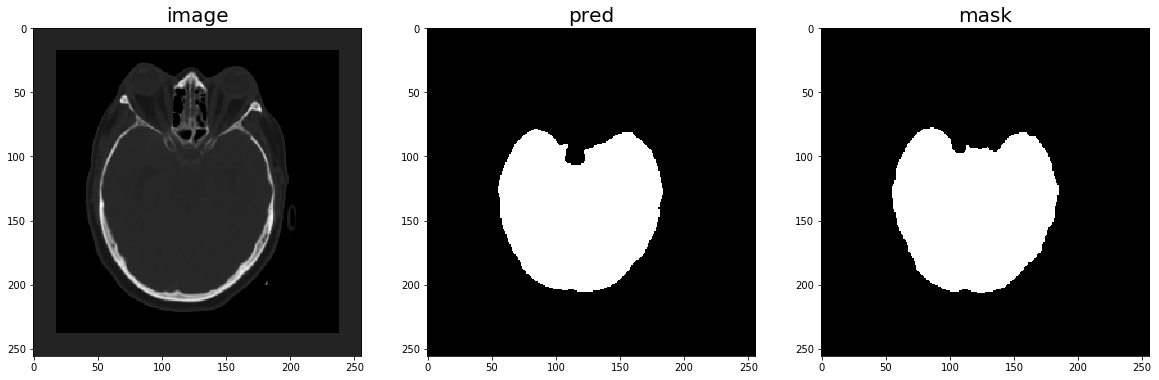

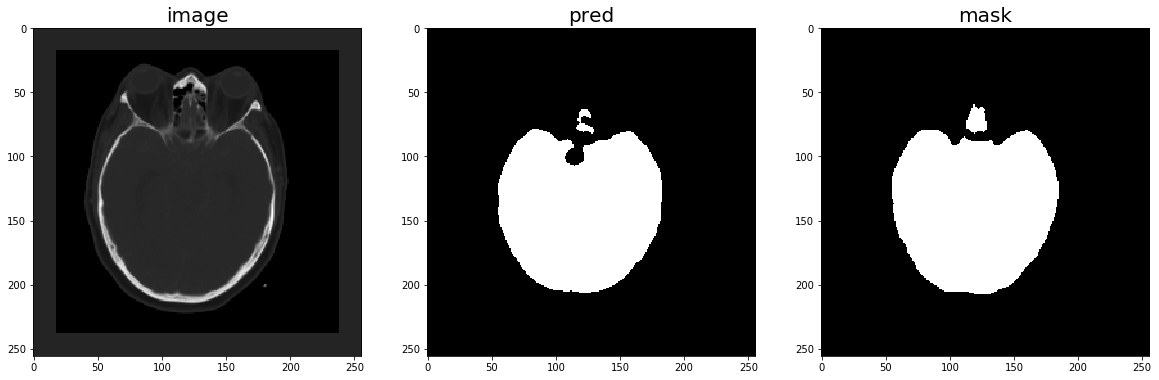

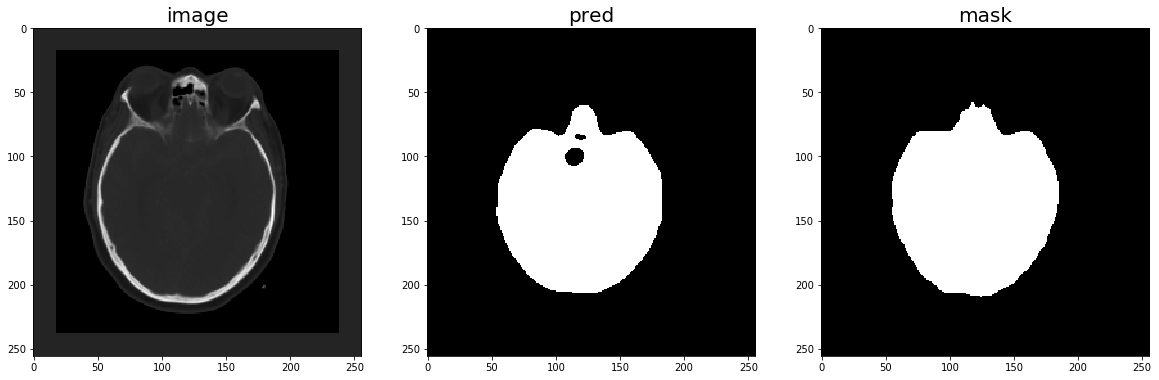

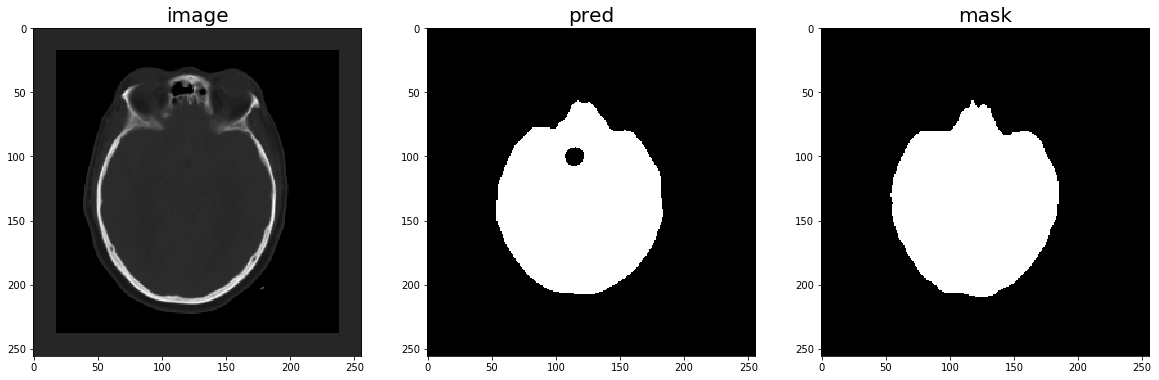

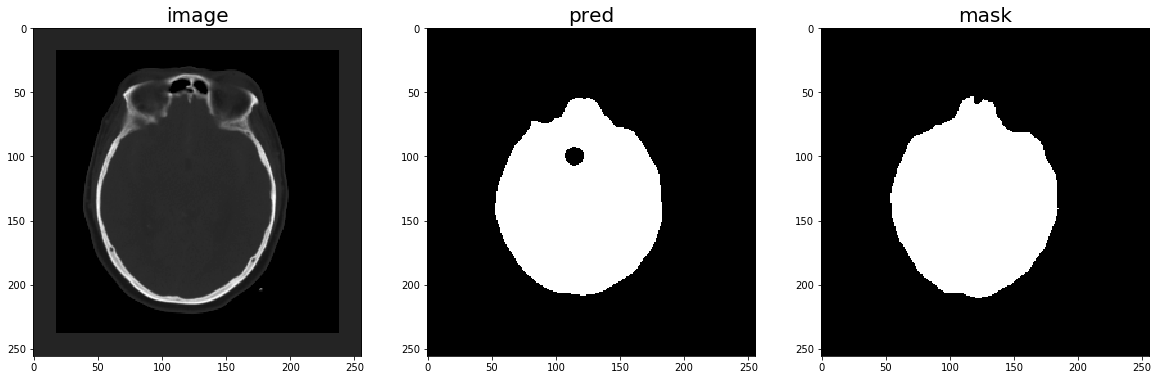

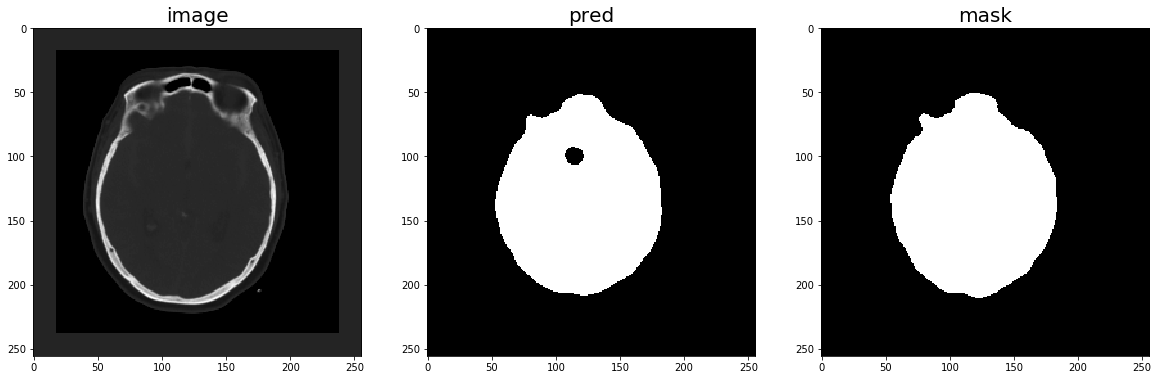

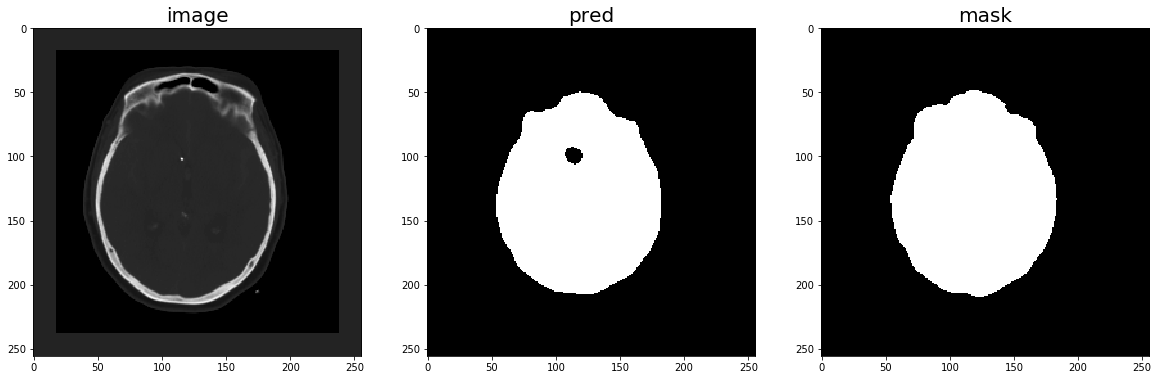

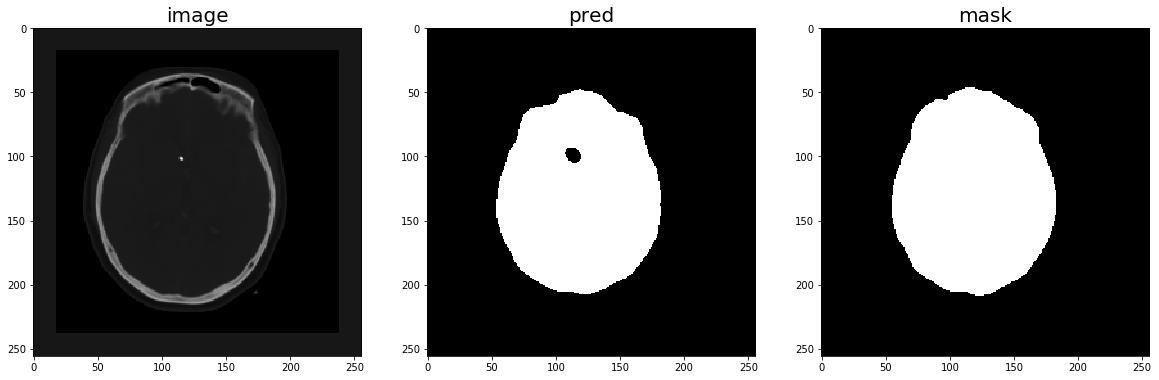

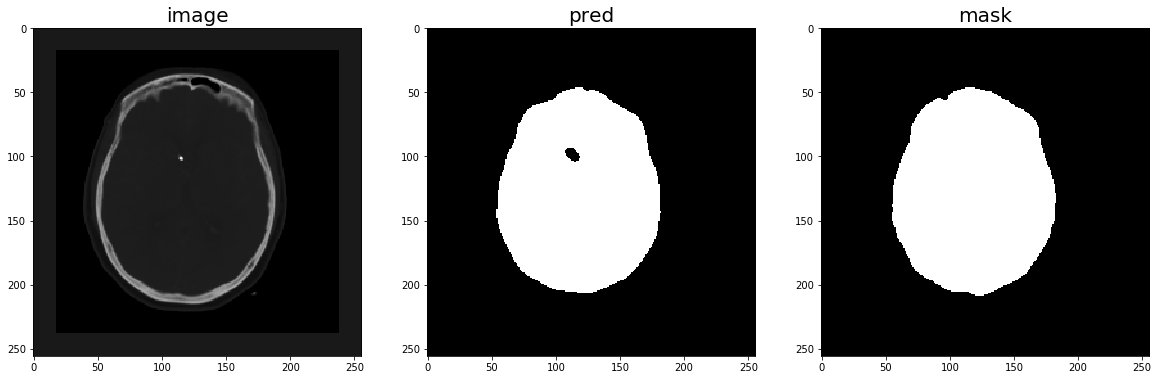

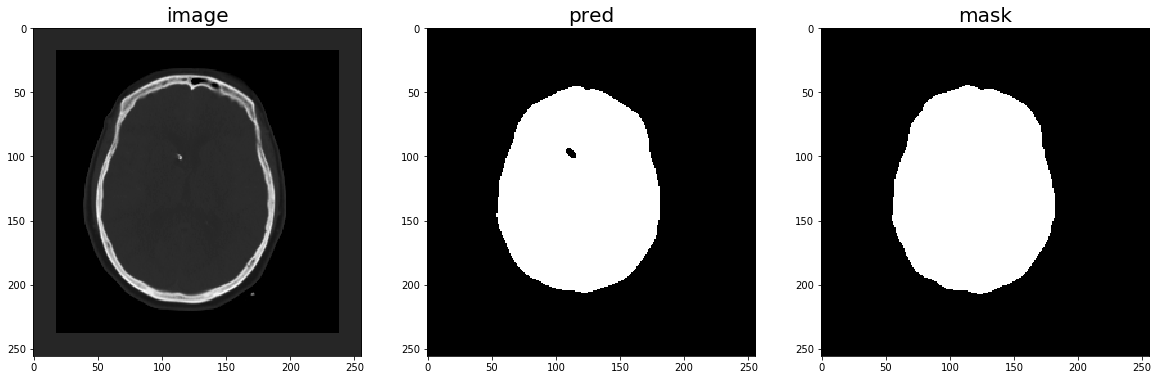

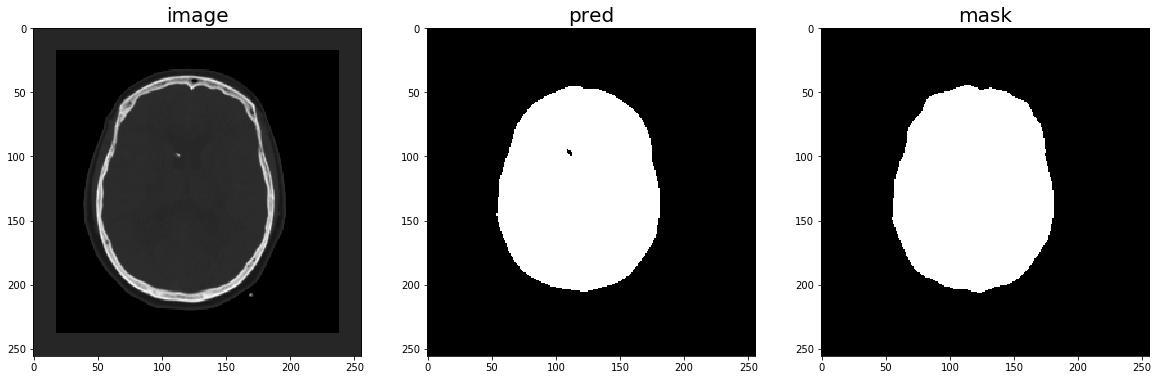

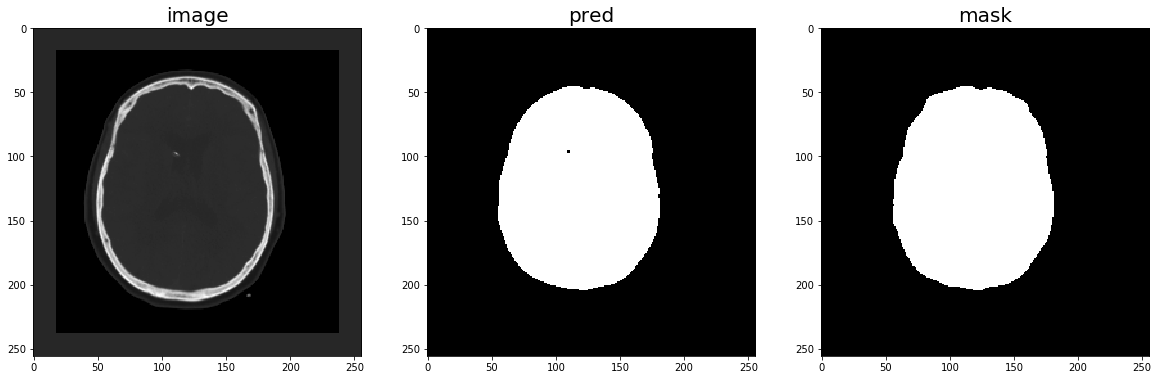

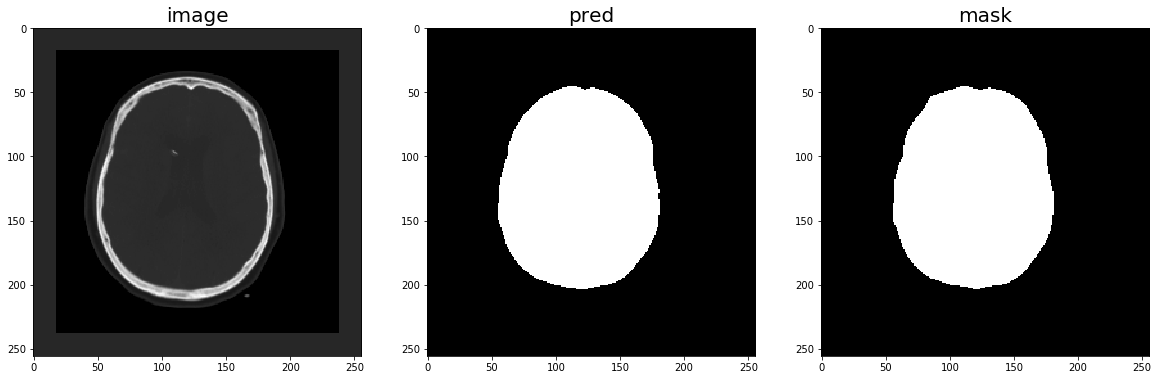

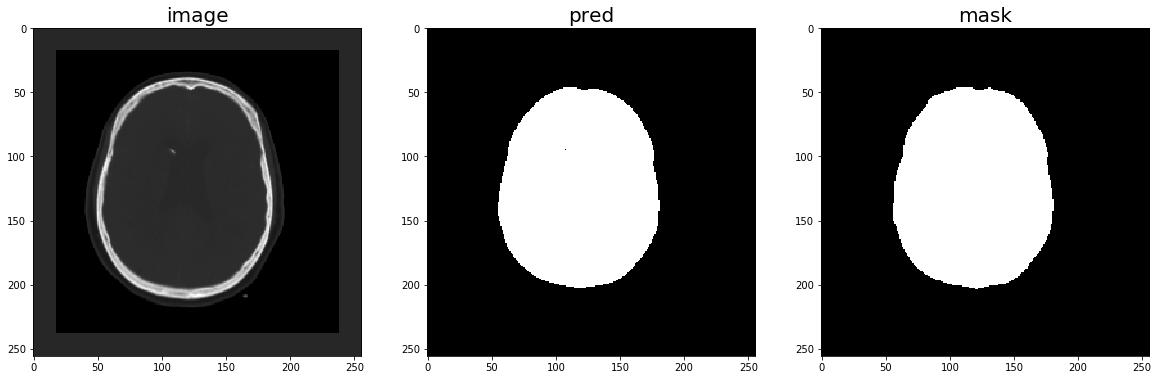

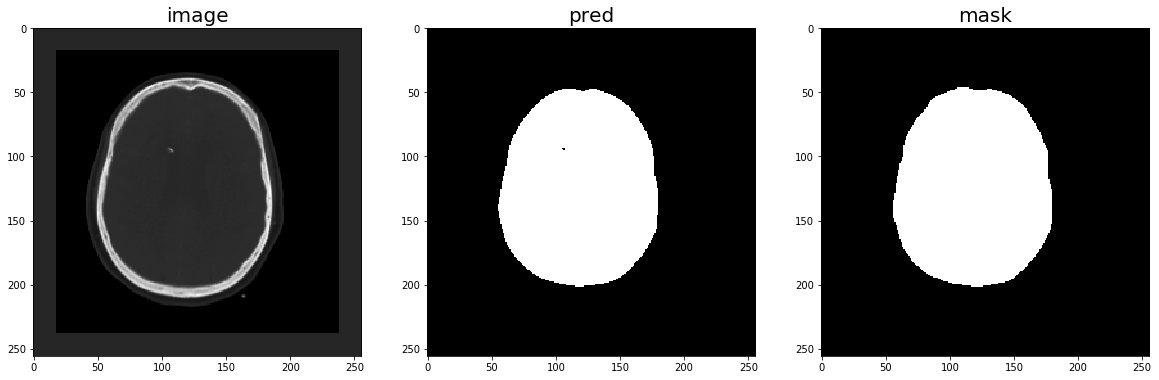

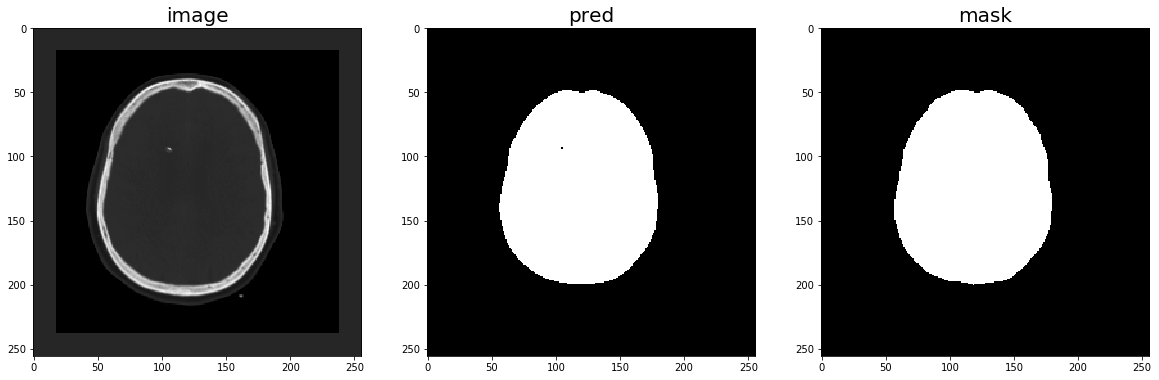

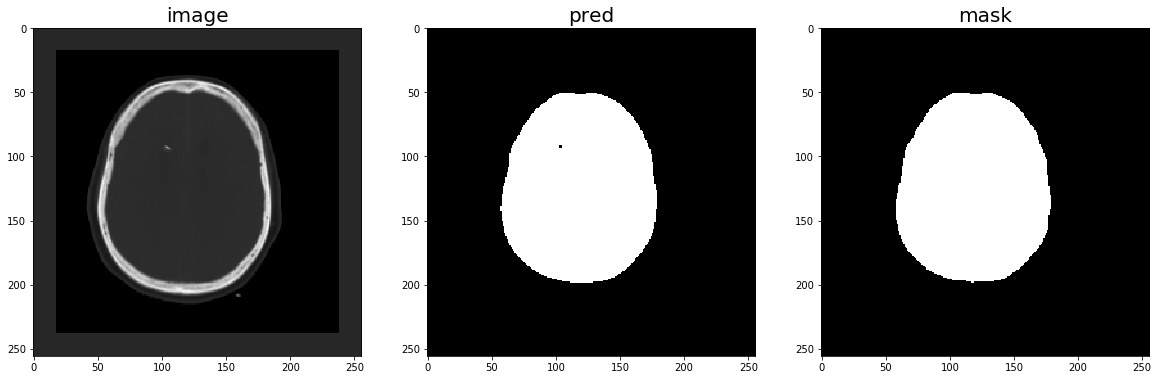

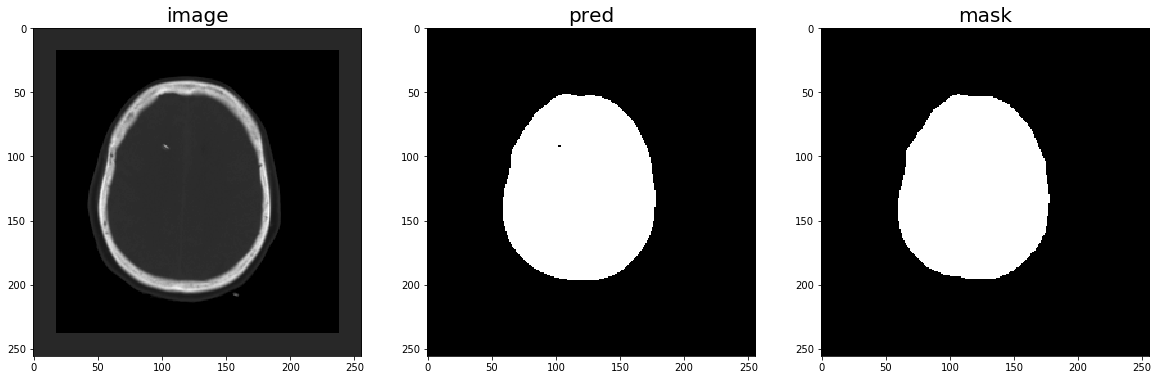

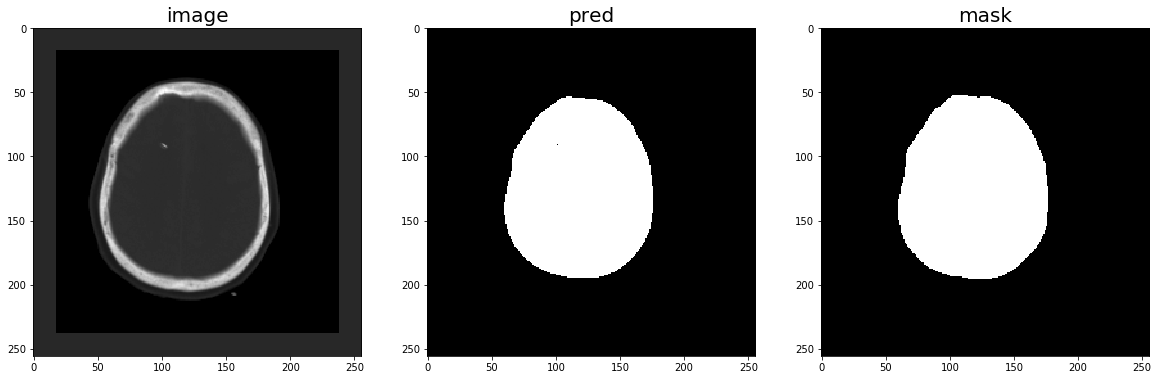

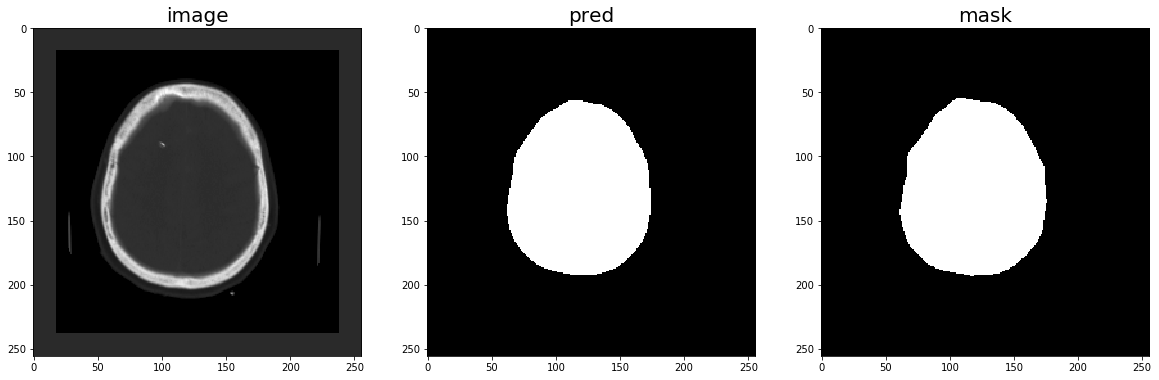

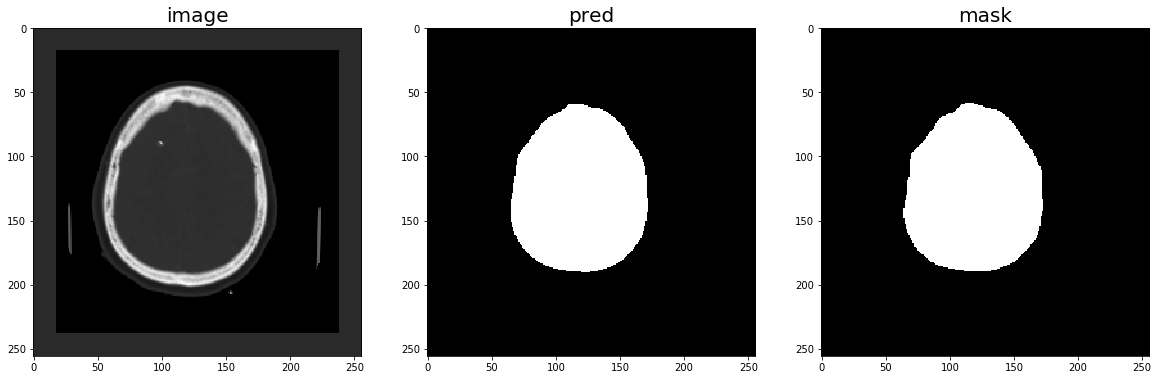

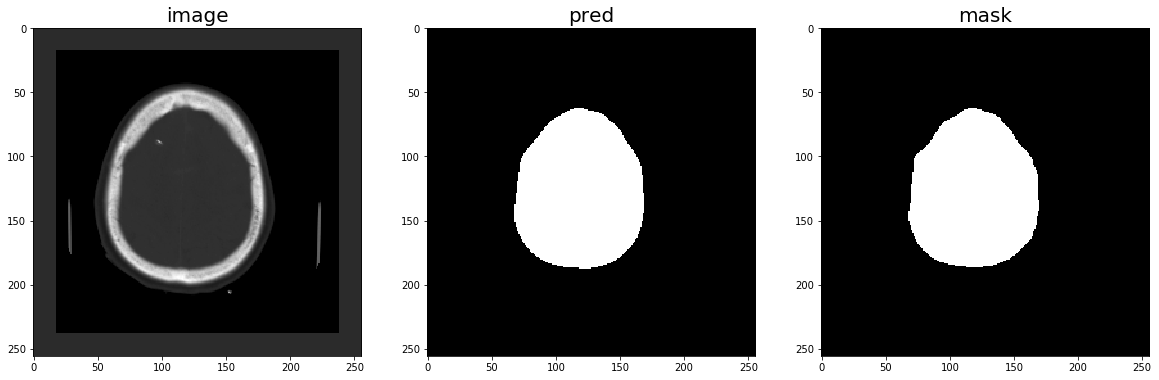

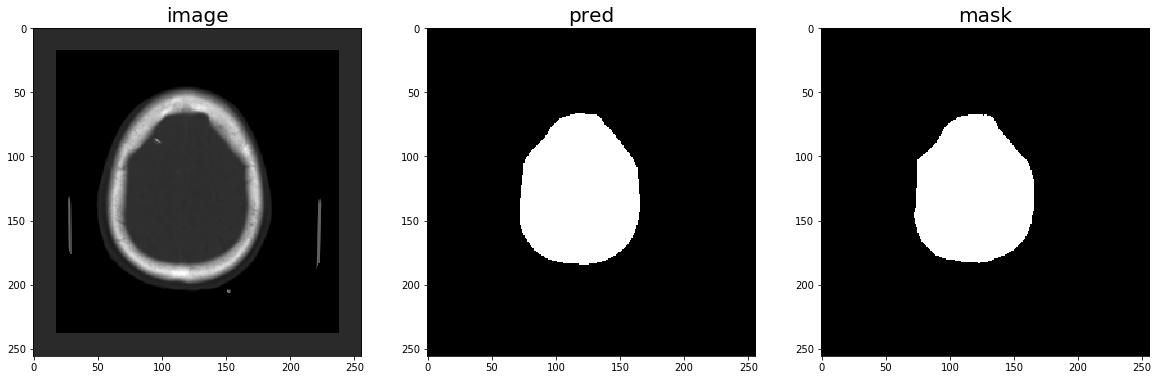

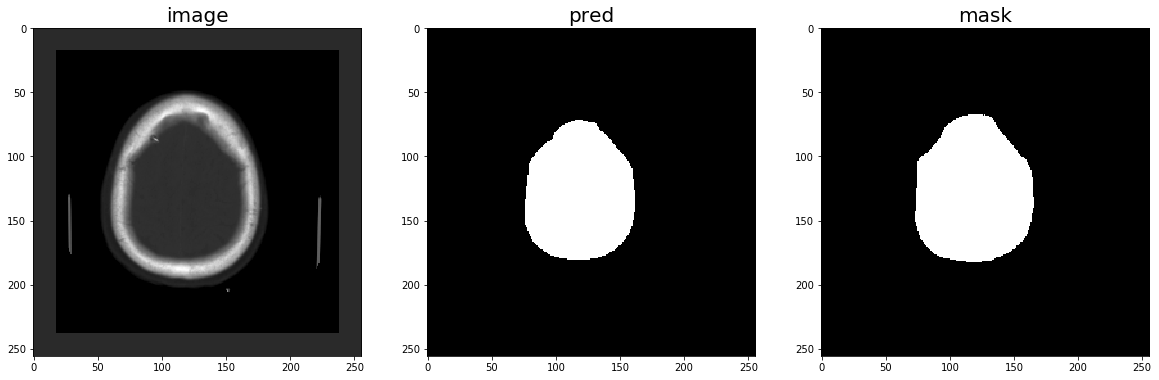

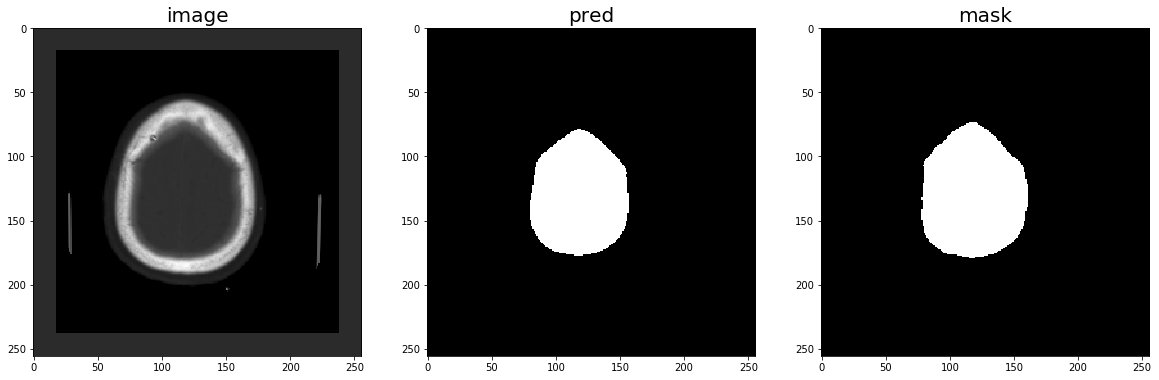

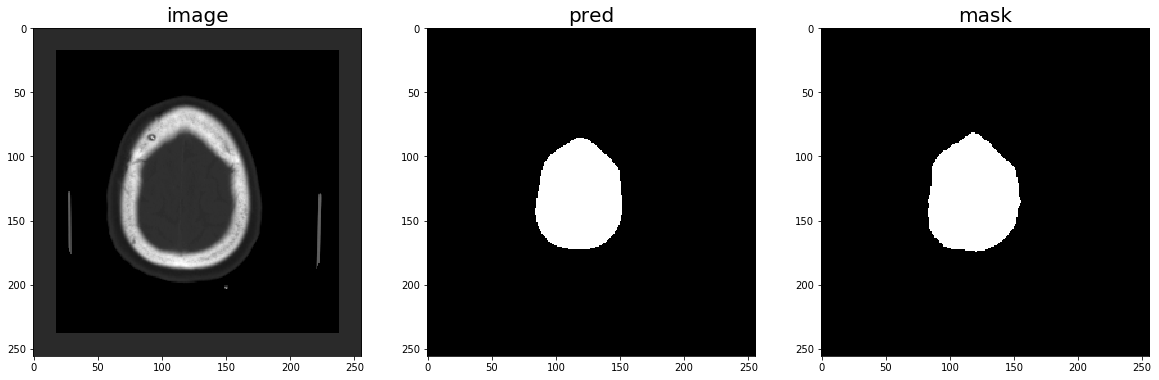

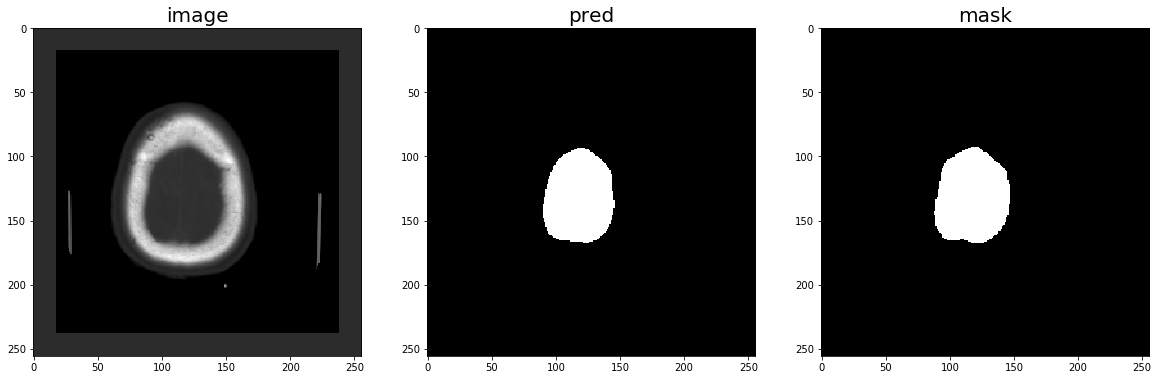

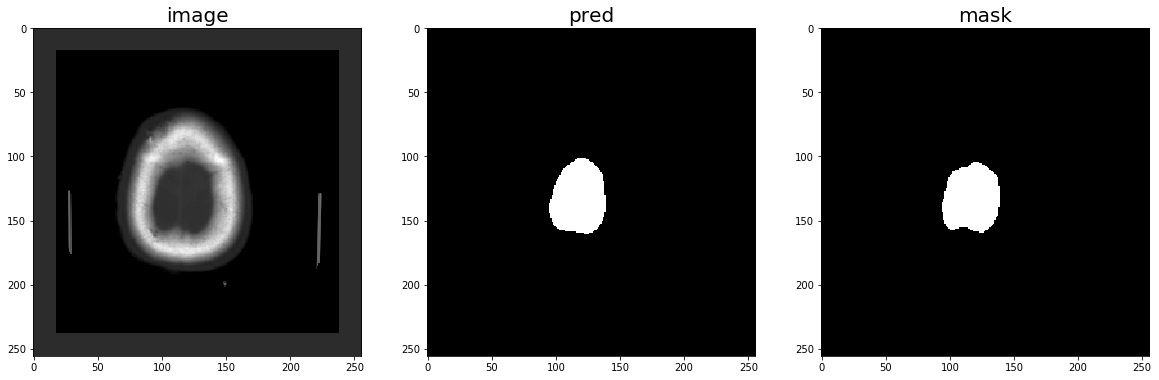

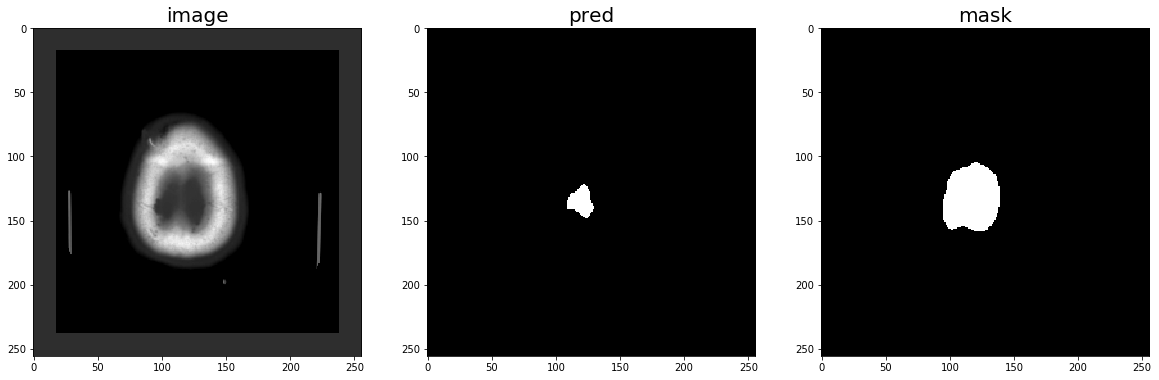

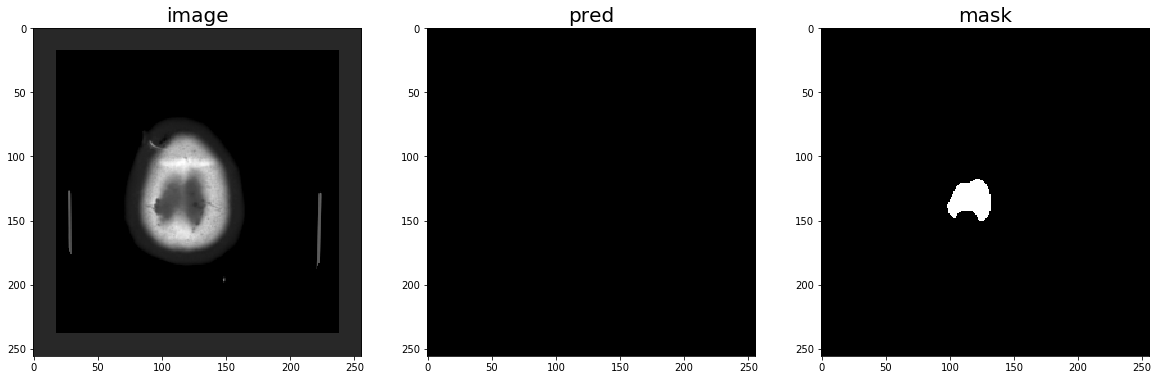

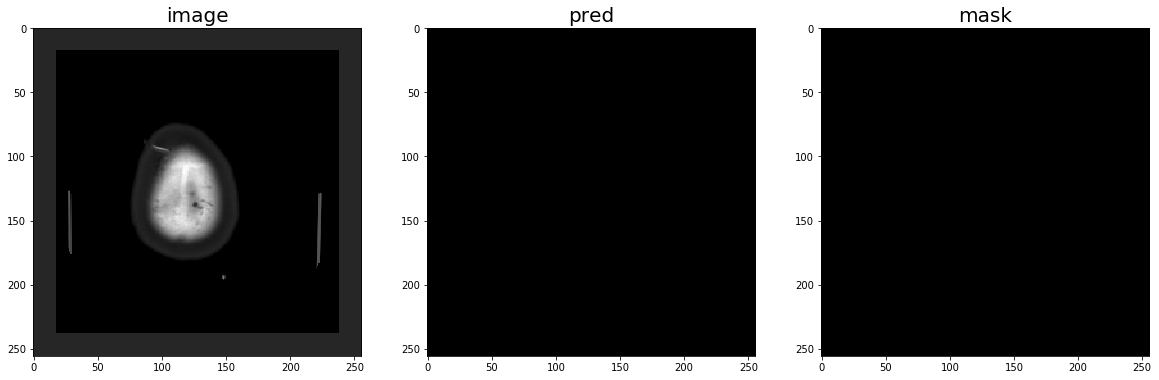

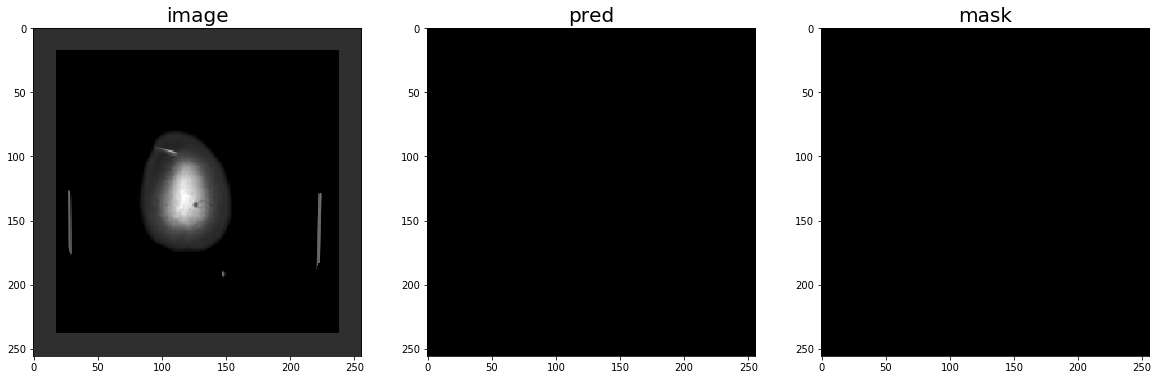

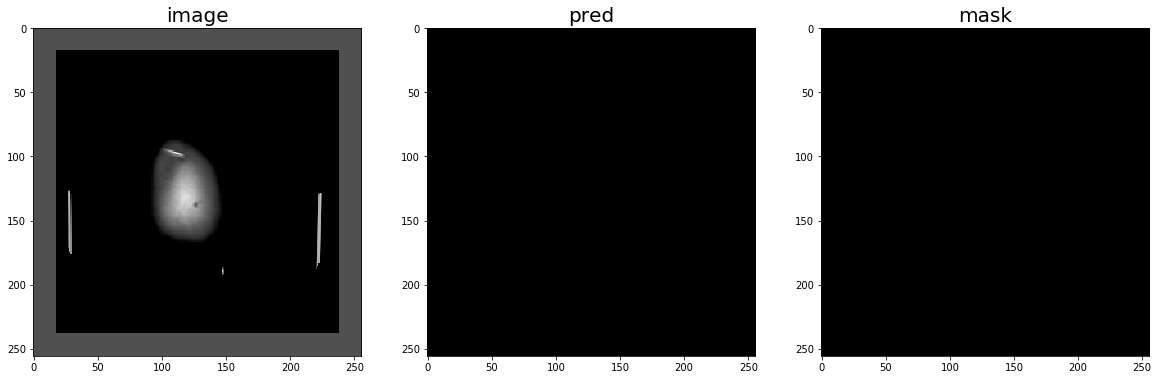

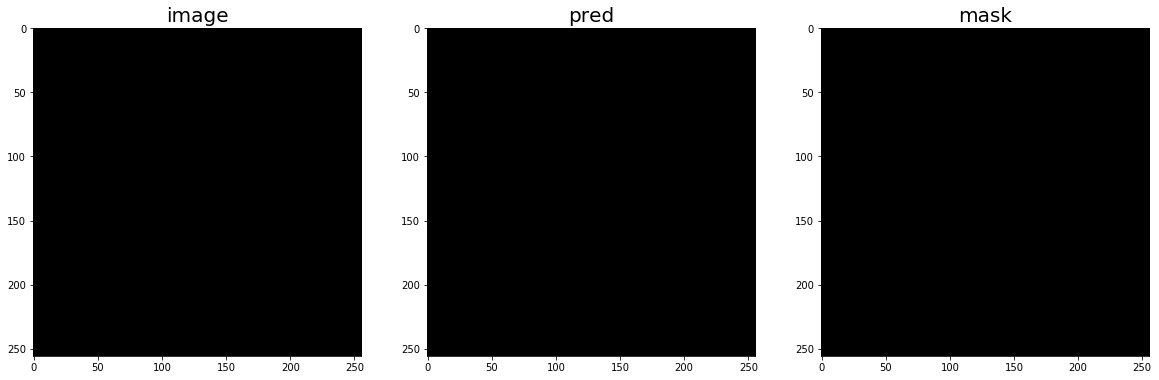

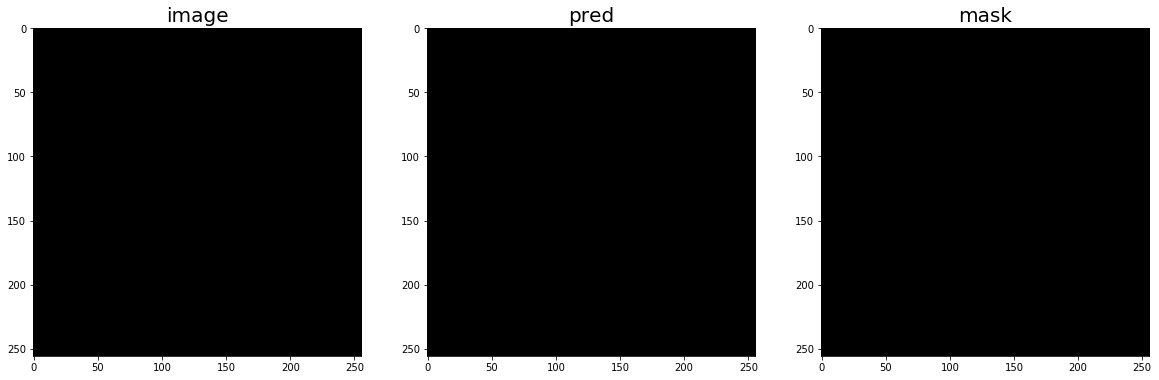

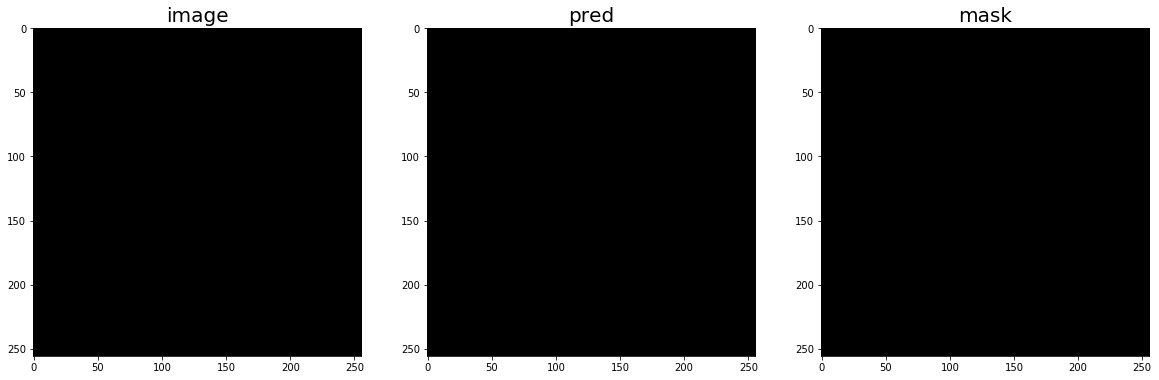

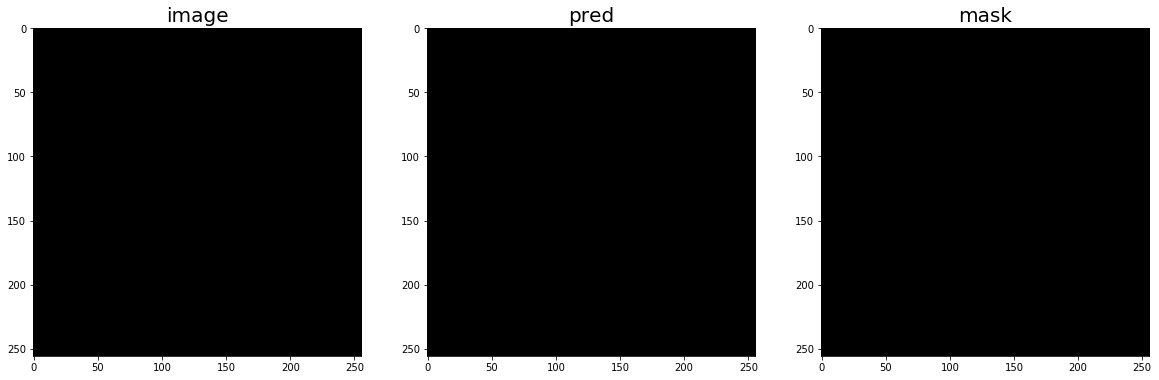

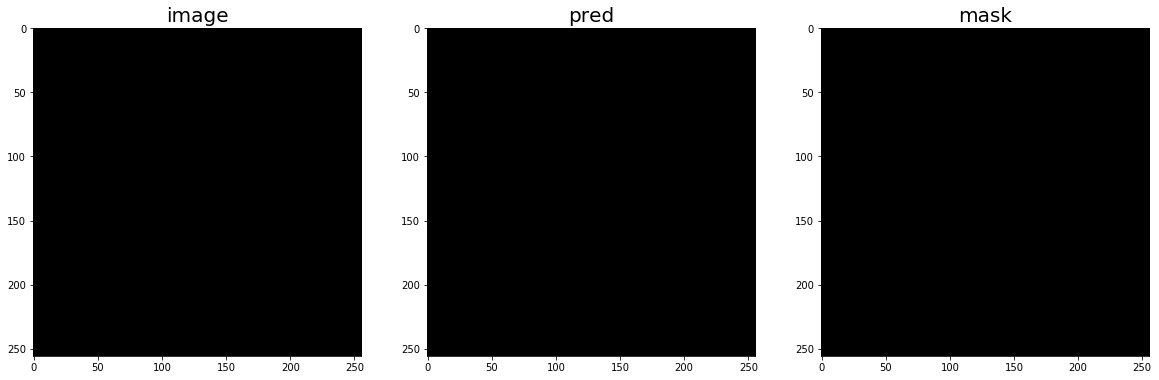

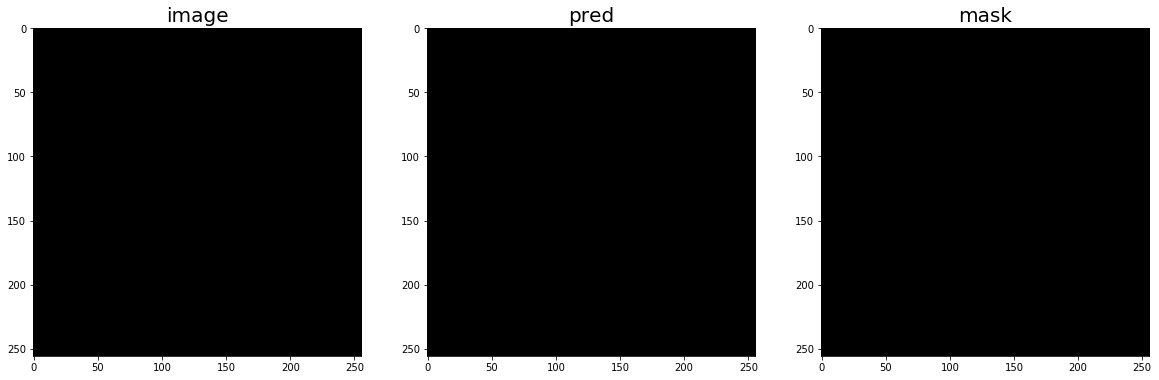

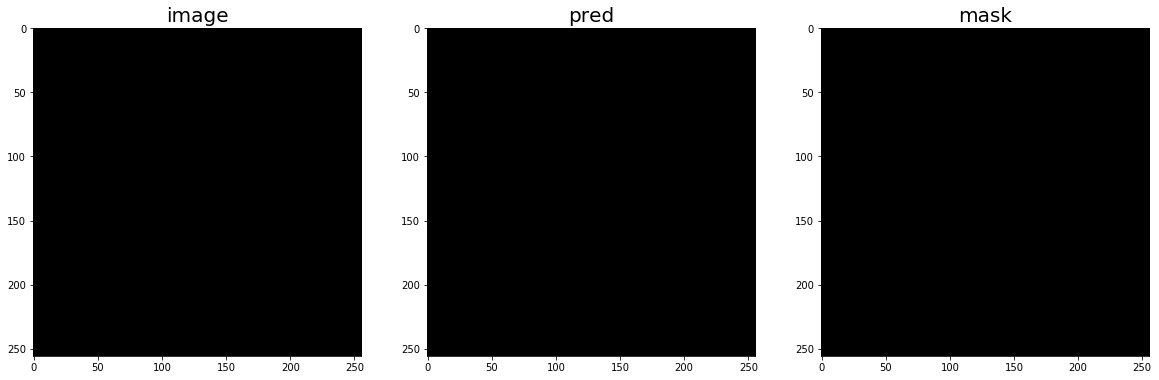

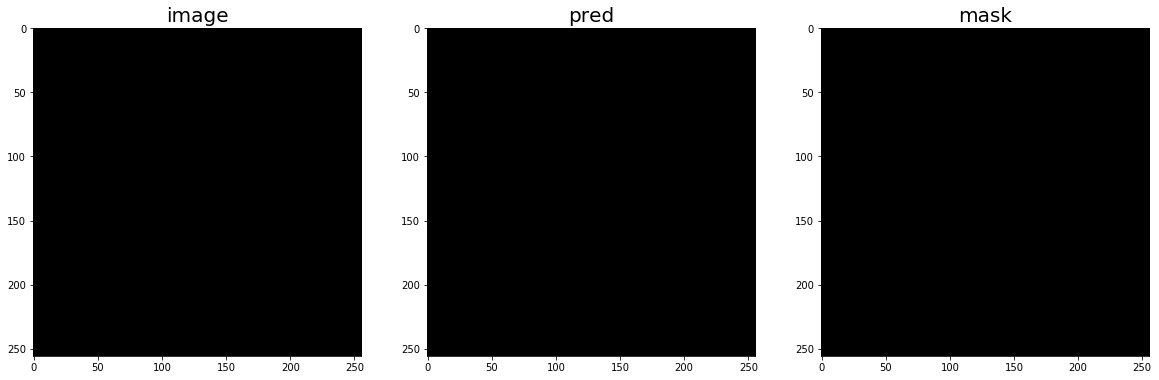

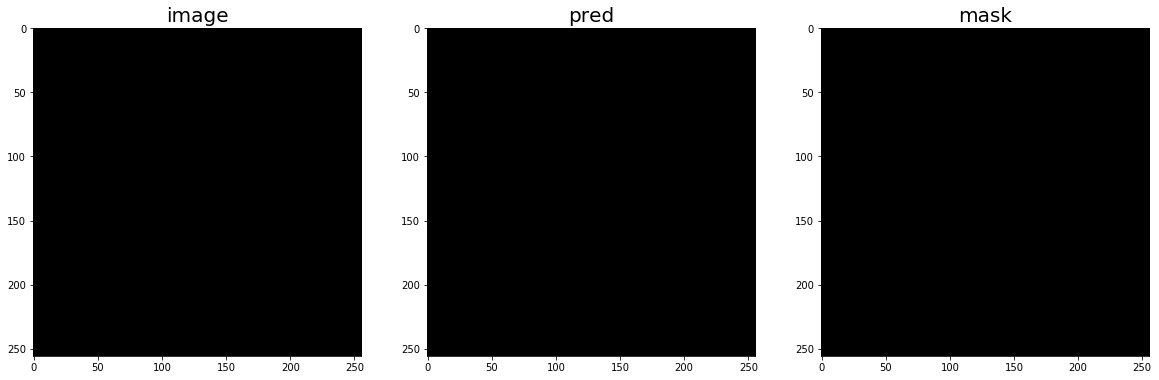

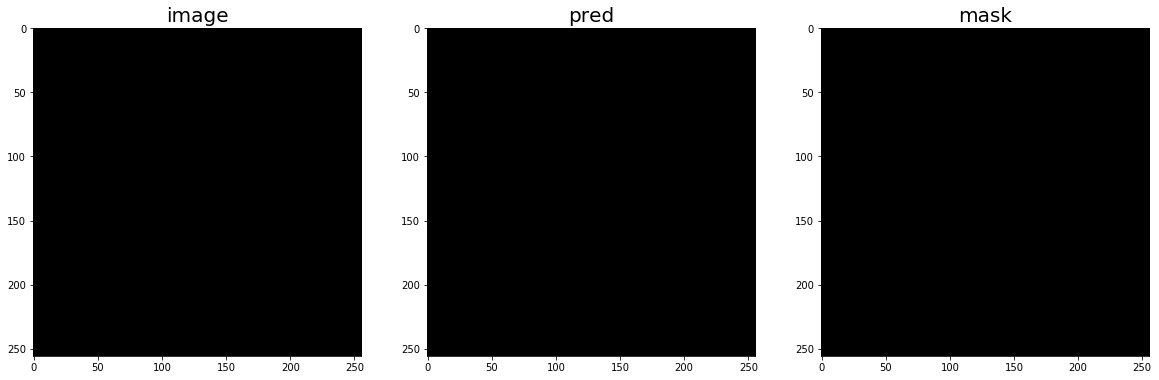

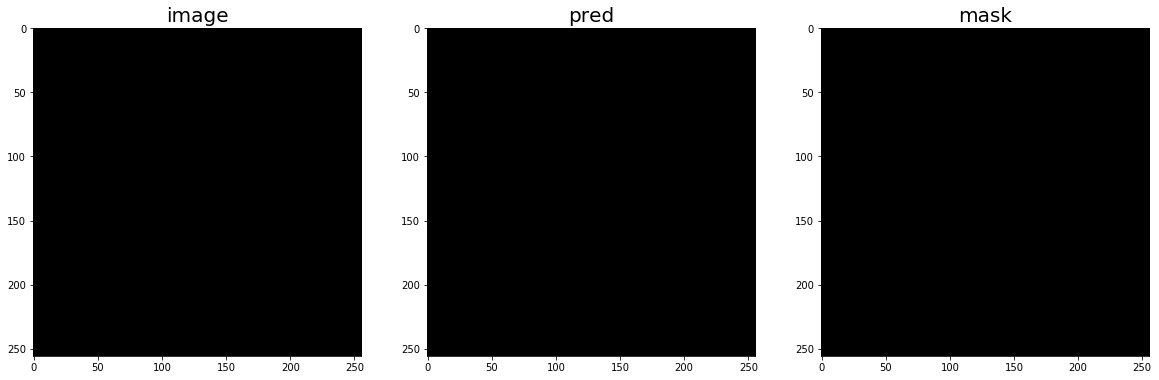

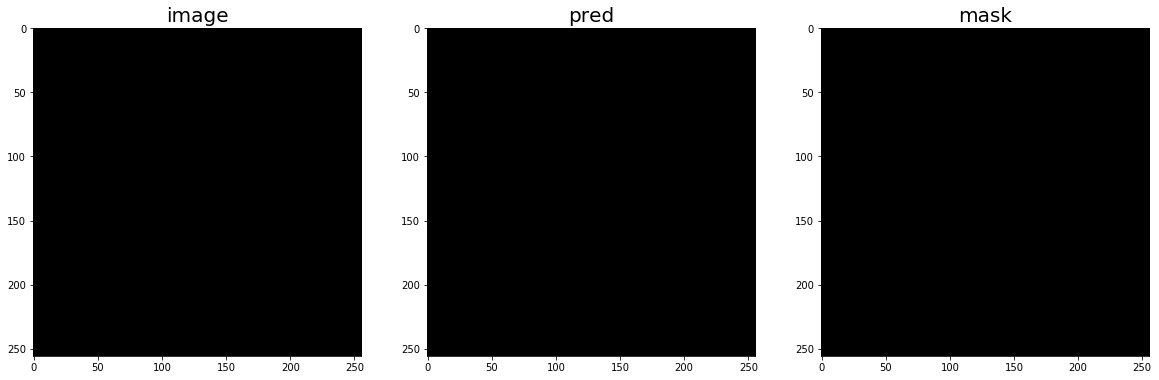

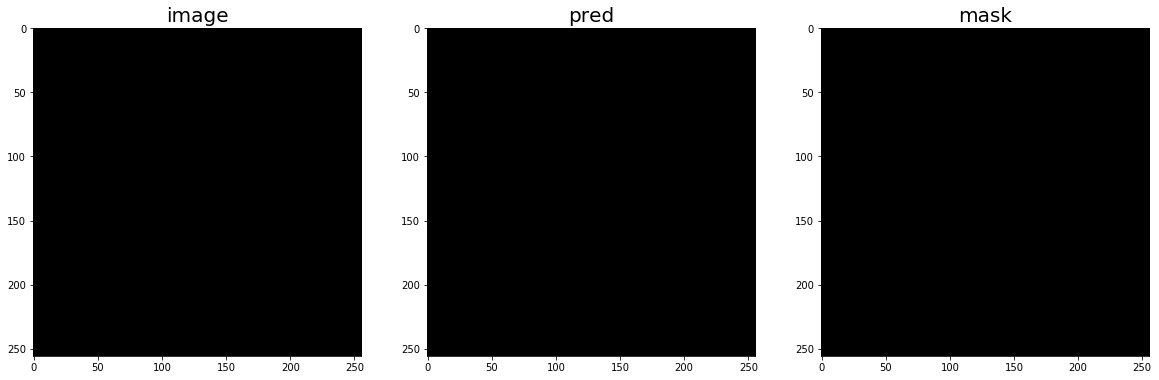

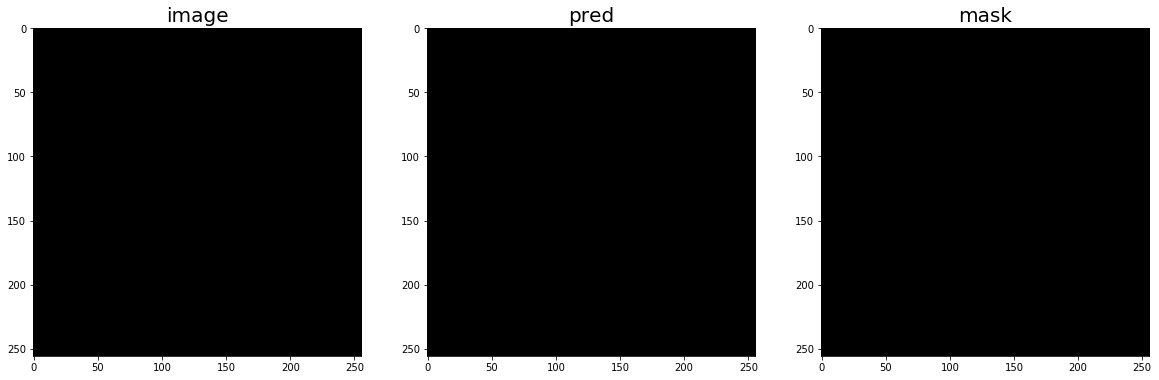

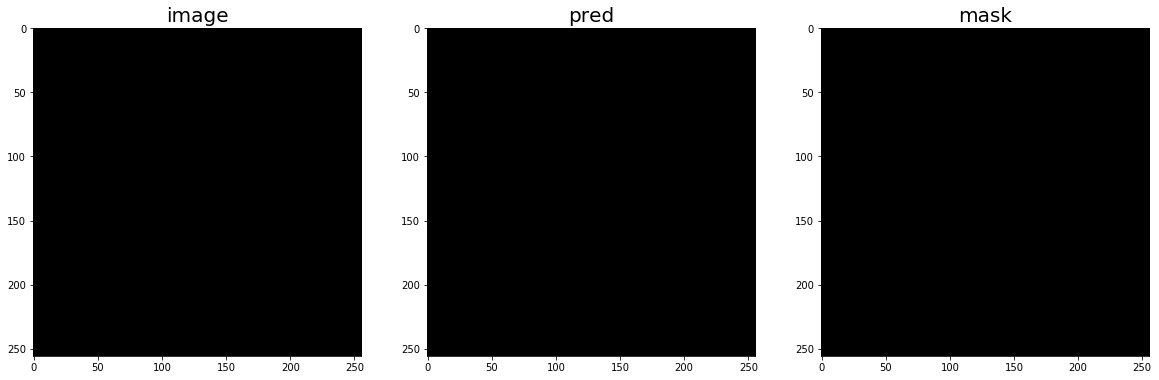

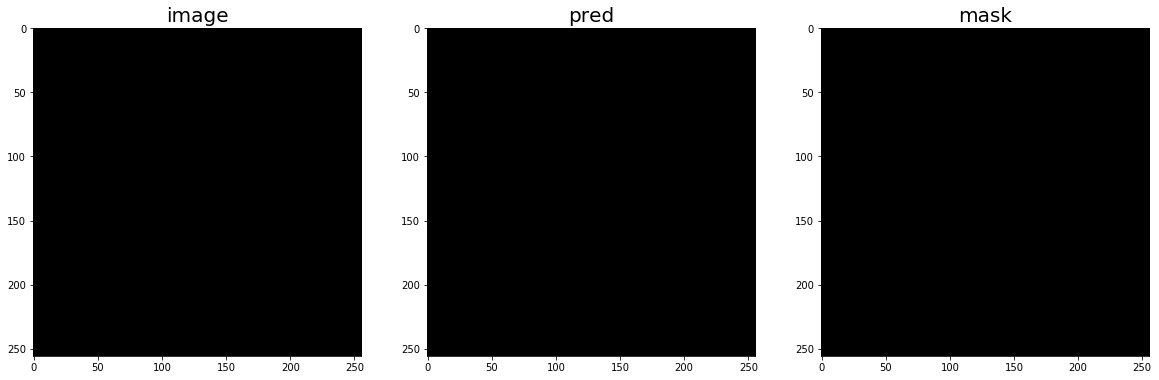

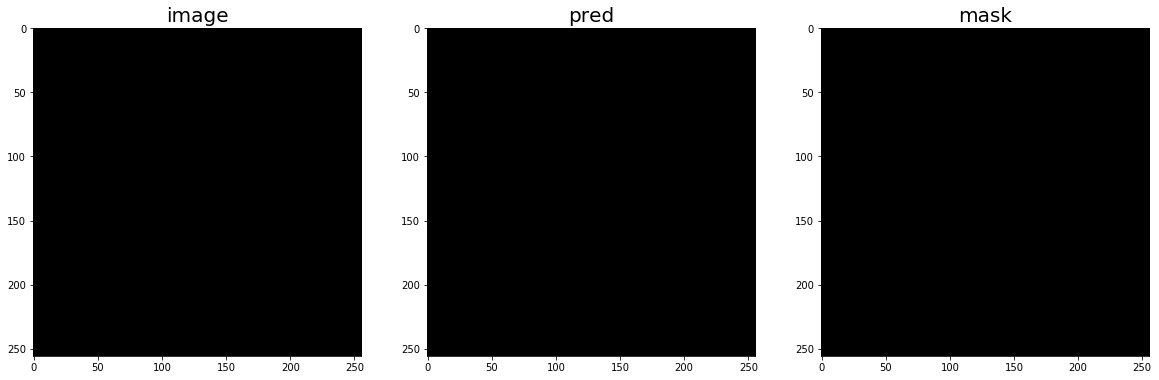

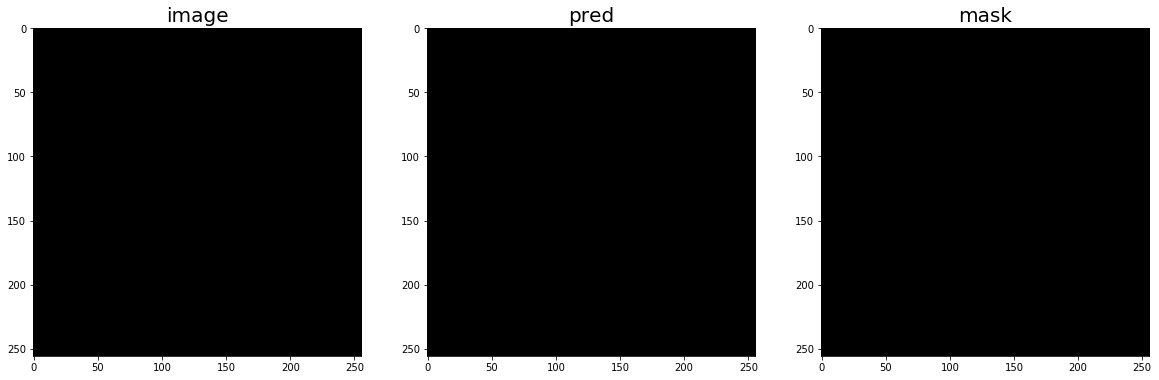

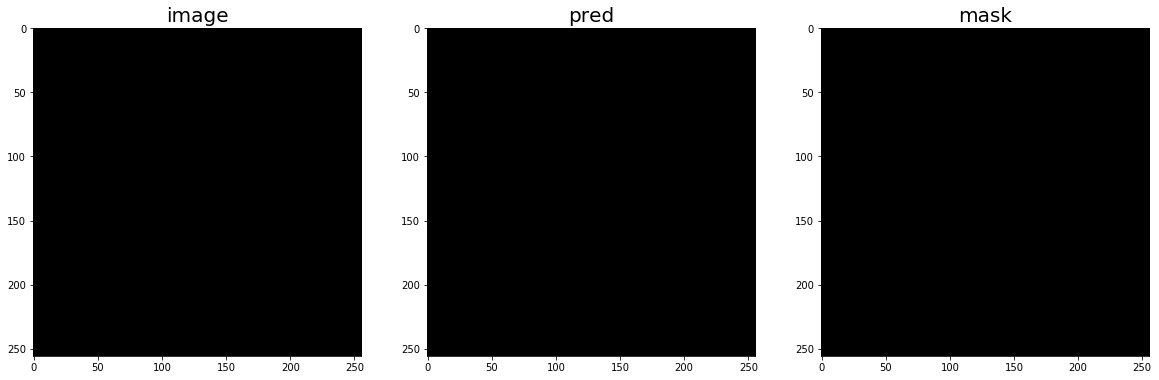

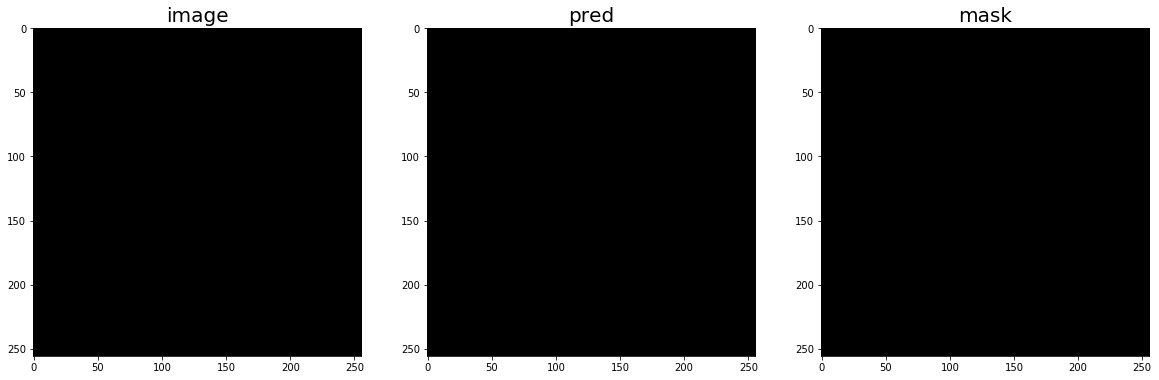

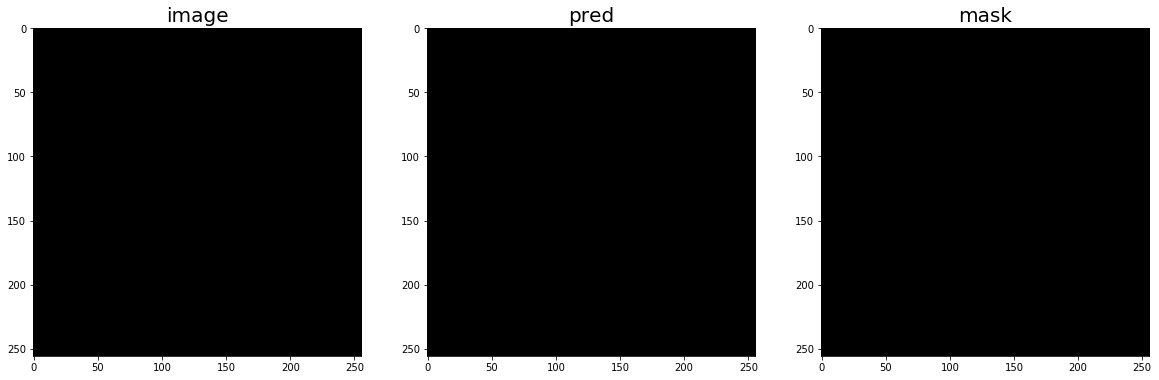

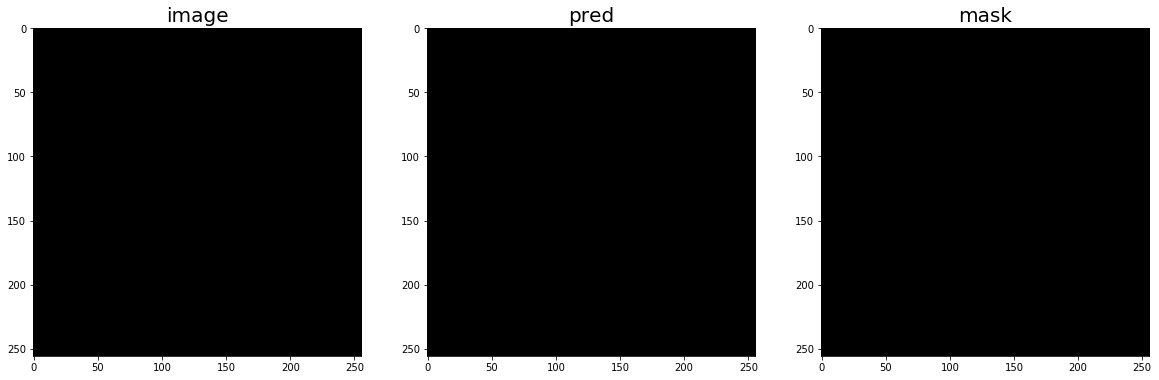

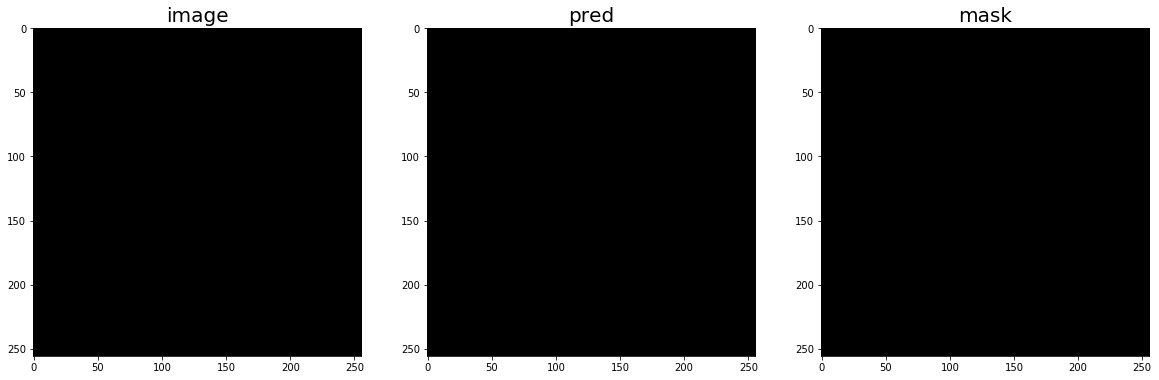

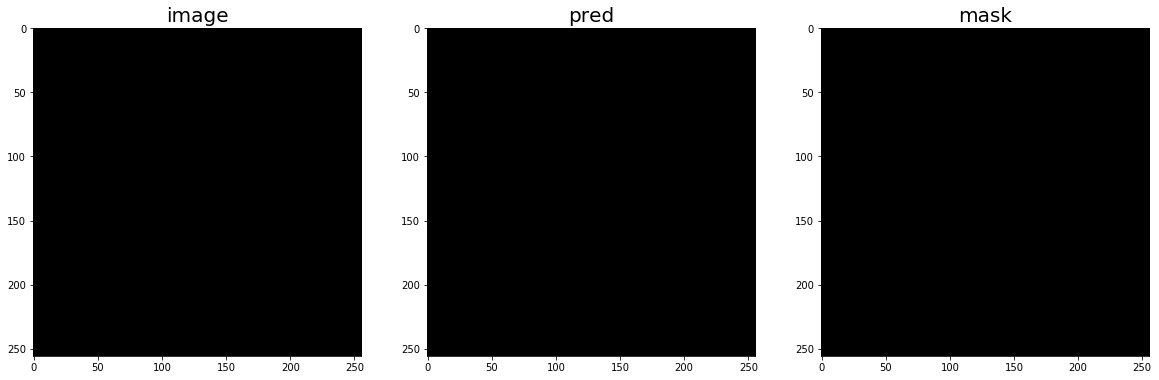

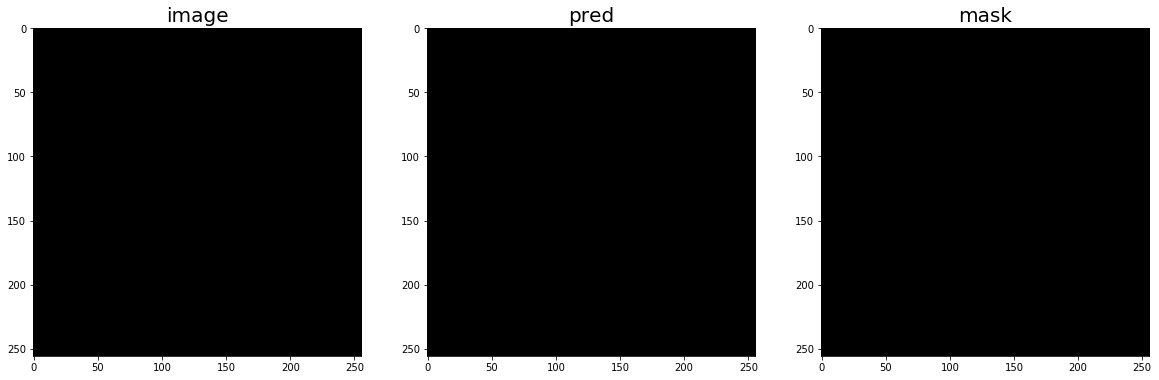

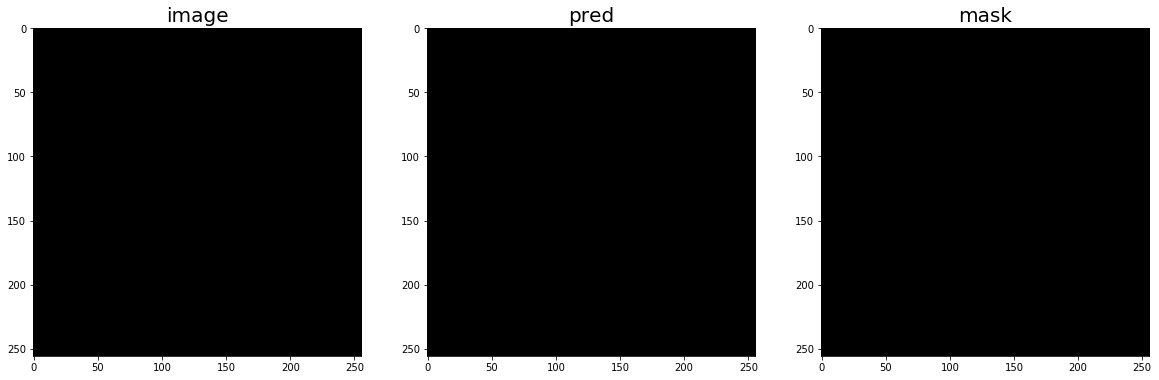

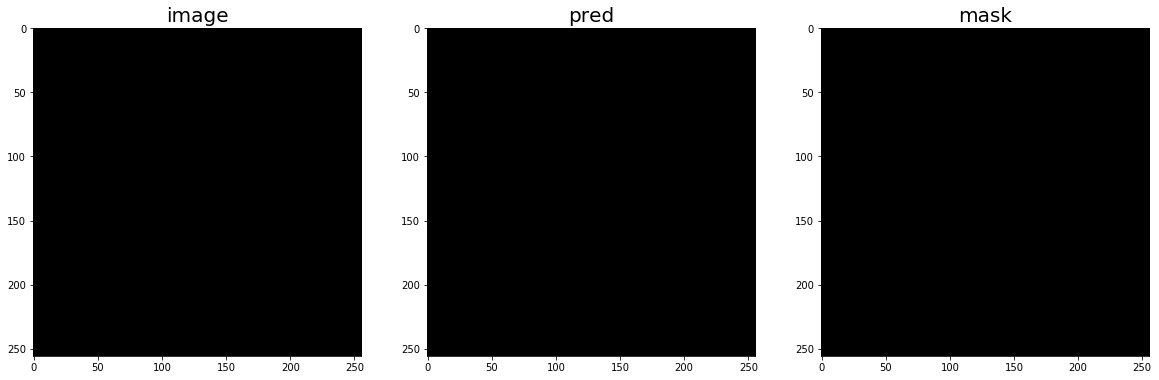

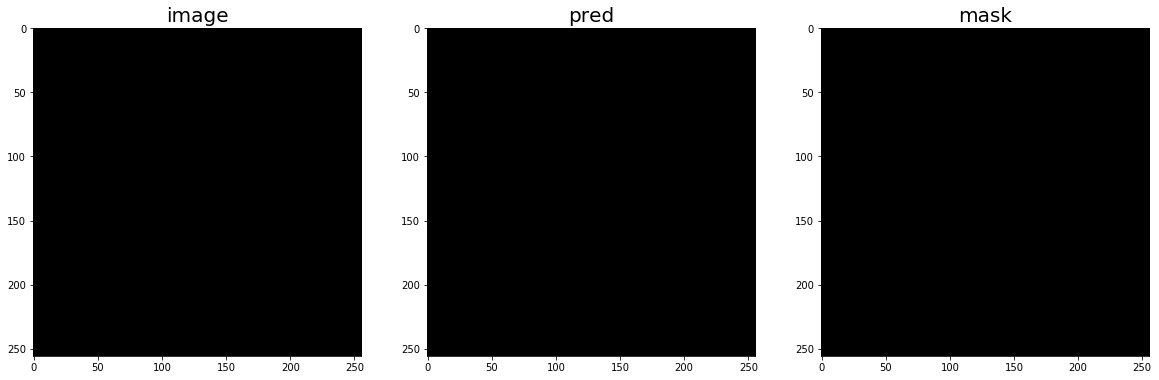

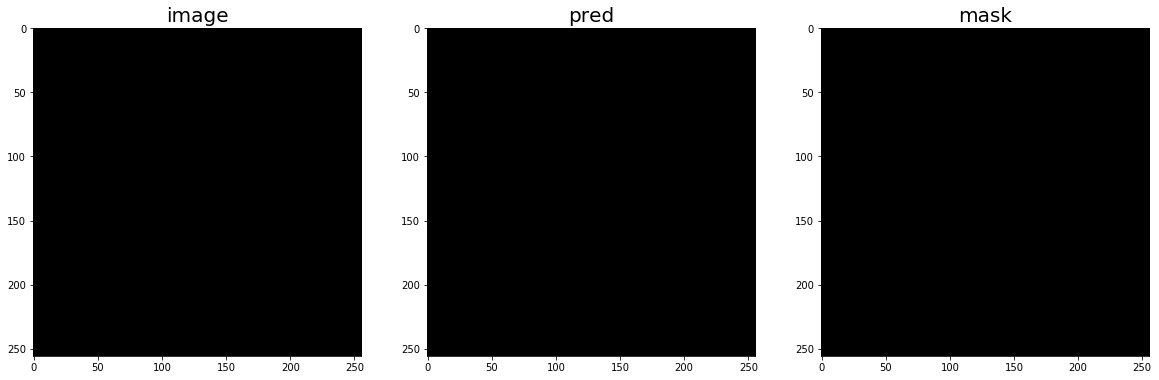

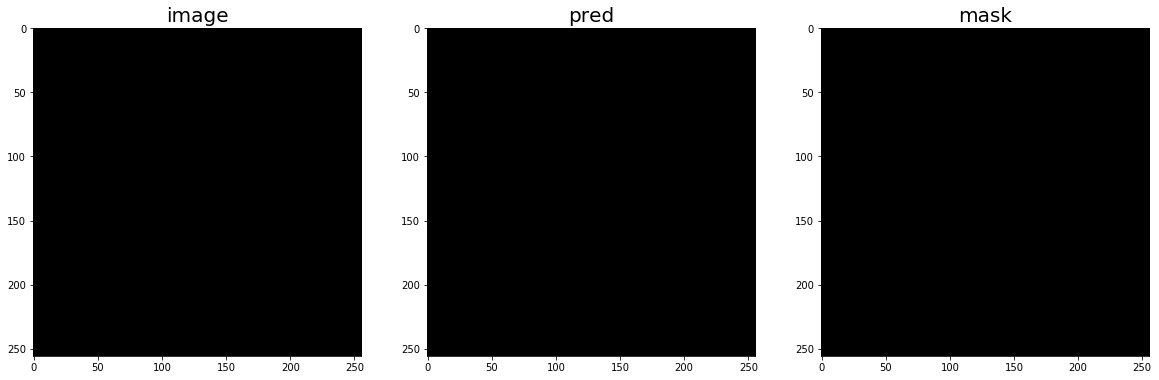

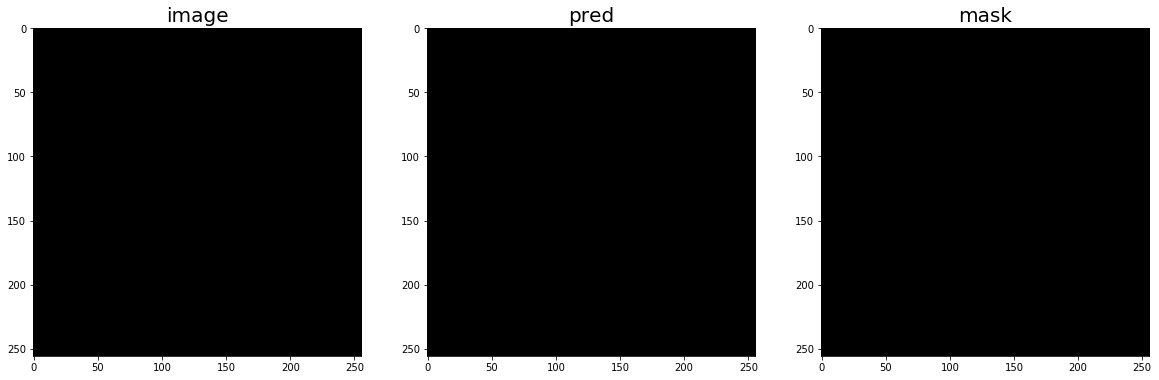

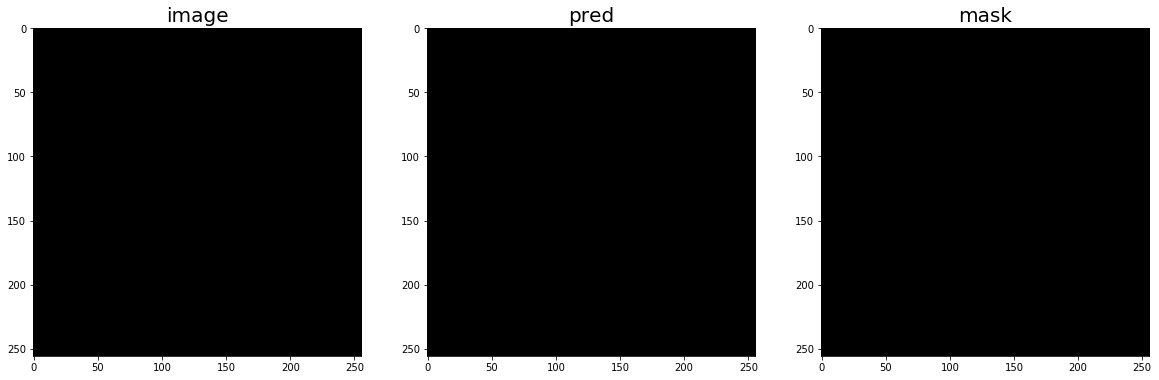

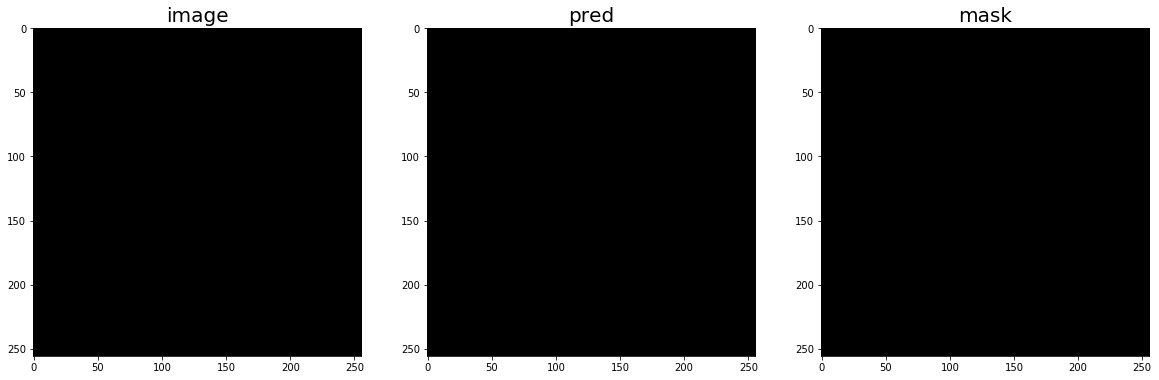

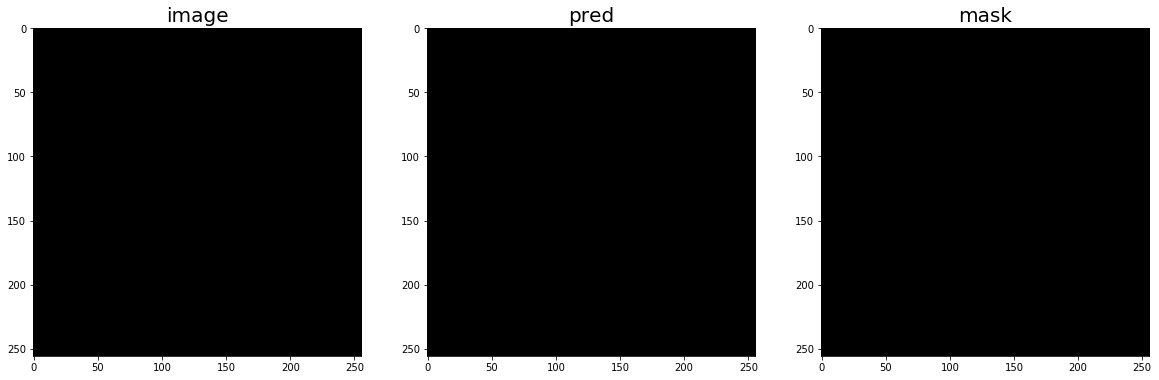

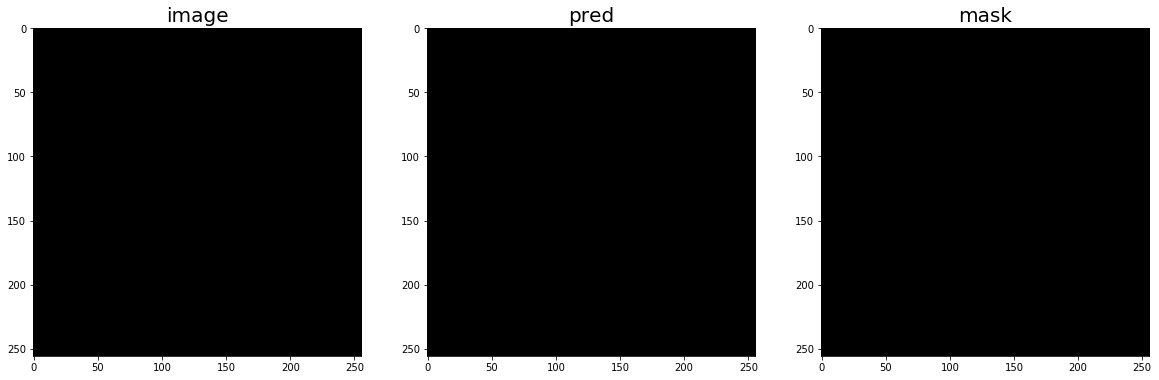

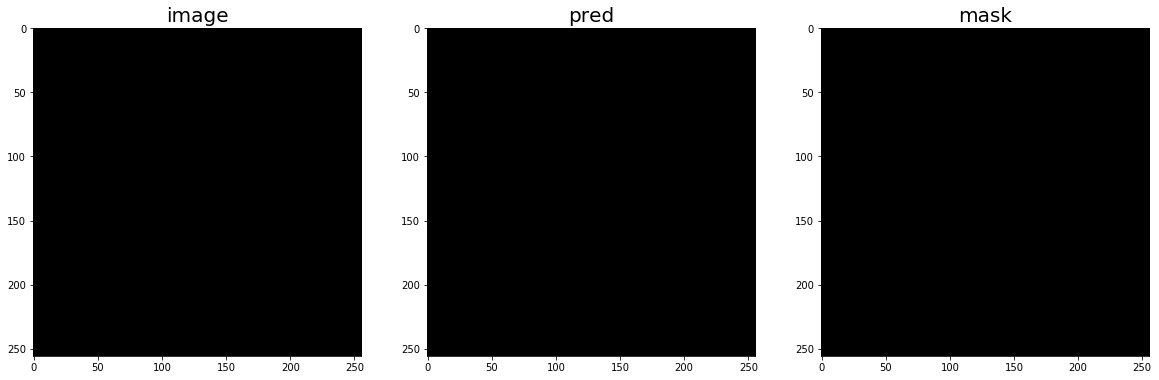

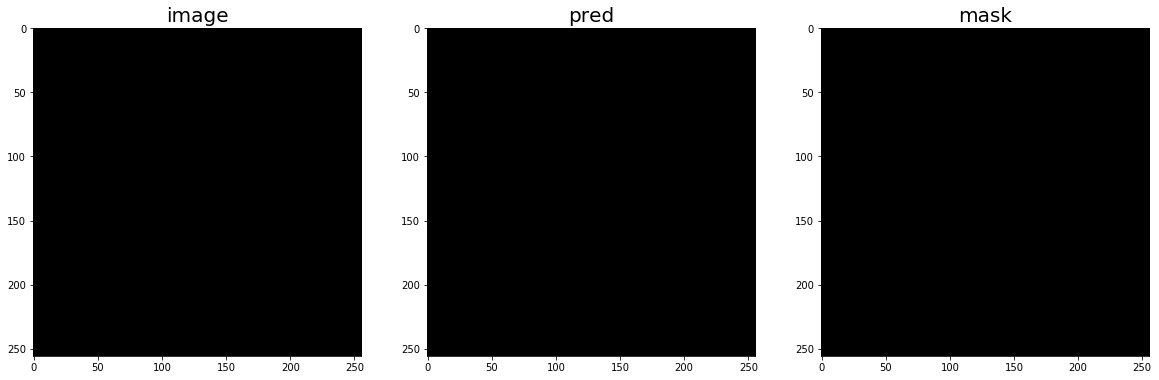

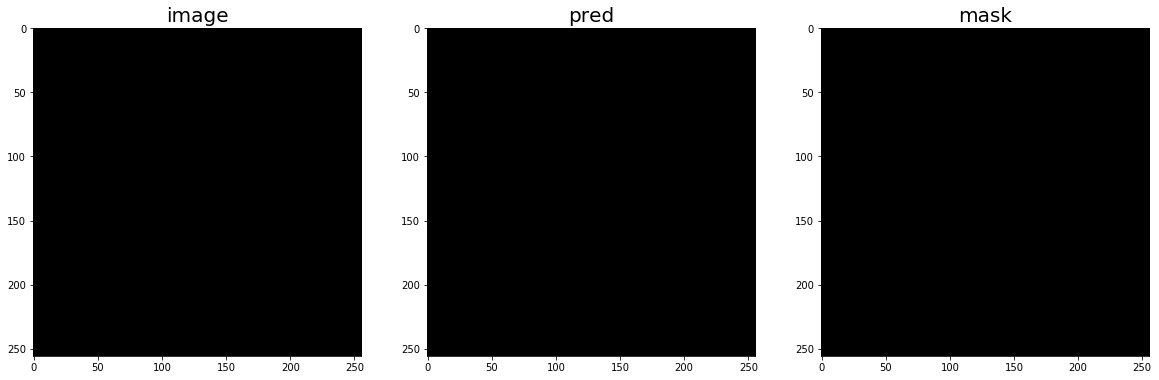

In [28]:
for i in range(image.shape[0]):
    plot_predictions(image[i], pred[i], mask[i])

In [19]:
eval_preds(preds, masks)

0.9650253707766764

## Skull Stripping with predicted Brain Mask

1. Predict Brain Mask
2. Perform weighted normalization part of raw image that corresponds to the brain mask
3. Extract the brain from the raw image using the mask

In [18]:
learner.load('DL_Brain_NoTL_CT_5_epochs_3e-2');

In [19]:
data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=3)
data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=3)

In [28]:
images, preds, masks = predict(learner, data1, validation=False)

In [29]:
for i in range(len(preds)):
    name = str(test1_mask[i]).split("/")[-1]
    brain_mask = preds[i]
    np.save("/data/public/Segmentation_Dataset/CT_Dataset/test1/brain_pred/{name}".format(name=name), brain_mask)
    image = images[i]
    image =  normalize(image, brain_mask)
    skull_stripped = extract_brain(image, brain_mask)
    np.save("/data/public/Segmentation_Dataset/CT_Dataset/test1/skull_stripped_pred/{name}".format(name=name), skull_stripped)

In [20]:
images, preds, masks = predict(learner, data2, validation=False)

In [21]:
for i in range(len(preds)):
    name = str(test2_mask[i]).split("/")[-1]
    brain_mask = preds[i]
    np.save("/data/public/Segmentation_Dataset/CT_Dataset/test2/brain_pred/{name}".format(name=name), brain_mask)
    image = images[i]
    image =  normalize(image, brain_mask)
    skull_stripped = extract_brain(image, brain_mask)
    np.save("/data/public/Segmentation_Dataset/CT_Dataset/test2/skull_stripped_pred/{name}".format(name=name), skull_stripped)